In [1]:
import numpy as np
import numpy.linalg as la 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from tqdm import trange

plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 20})
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
dataf = pd.read_csv('premier_league_2013_2014.dat', sep=',', header=None)
dataf.columns = ['goals_home', 'goals_away', 'home_team', 'away_team']
dataf.head()

,goals_home,goals_away,home_team,away_team
0,1.0,3.0,0.0,1.0
1,2.0,0.0,0.0,2.0
2,0.0,0.0,0.0,3.0
3,2.0,0.0,0.0,4.0
4,1.0,1.0,0.0,5.0


In [19]:
def enforce_corner_constraint(theta, n_teams):
    theta[0] = theta[n_teams] = 0
    return theta

def propose_samples(current, sigma):
    I = np.eye(current.shape[0])
    proposal = np.random.multivariate_normal(current, cov=I*sigma**2)
    return proposal

def compute_hyper_prior_probabilities(eta):
    tau1 = 0.0001
    alpha = beta = 0.1

    mu_attack_logprob = st.norm(0, 1/np.sqrt(tau1)).logpdf(eta[0])
    mu_defense_logprob = st.norm(0, 1/np.sqrt(tau1)).logpdf(eta[1])
    tau_attack_logprob = st.gamma(alpha, scale=1/beta).logpdf(eta[2])
    tau_defense_logprob = st.gamma(alpha, scale=1/beta).logpdf(eta[3])

    eta_logprob = mu_attack_logprob + mu_defense_logprob + tau_attack_logprob + tau_defense_logprob
    return eta_logprob

def compute_prior_probabilities(eta, theta, n_teams):
    tau0 = 0.0001

    mu_attack = eta[0]
    mu_defense = eta[1]
    tau_attack = eta[2]
    tau_defense = eta[3]
    
    home = theta[-1]
    attack = theta[:n_teams]
    defense = theta[n_teams:-1]

    home_logprob = st.norm(0, 1/np.sqrt(tau0)).logpdf(home)
    attack_logprob = st.norm(mu_attack, 1/np.sqrt(tau_attack)).logpdf(attack)
    defense_logprob = st.norm(mu_defense, 1/np.sqrt(tau_defense)).logpdf(defense)

    theta_prob = home_logprob + np.sum(attack_logprob + defense_logprob)
    return theta_prob

def compute_likelihood(theta, n_teams, dataf):
    
    goals_home = dataf['goals_home'].values.astype(int)
    goals_away = dataf['goals_away'].values.astype(int)
    home_team = dataf['home_team'].values.astype(int)
    away_team = dataf['away_team'].values.astype(int)

    home = theta[-1]
    attack = theta[:n_teams]
    defense = theta[n_teams:-1]

    theta_home = np.exp(home + attack[home_team] - defense[away_team])
    theta_away = np.exp(attack[away_team] - defense[home_team])
    
    loglikelihood_home = st.poisson(theta_home).logpmf(goals_home)
    loglikelihood_away = st.poisson(theta_away).logpmf(goals_away)

    loglikelihood = np.sum(loglikelihood_home + loglikelihood_away)
    return loglikelihood

def compute_probabilities(eta, theta, n_teams, dataf):
    eta_logprob = compute_hyper_prior_probabilities(eta)
    theta_logprob = compute_prior_probabilities(eta, theta, n_teams)
    loglikelihood = compute_likelihood(theta, n_teams, dataf)
    logprob = eta_logprob + theta_logprob + loglikelihood
    return logprob

def metropolis_hastings(n_its, sigma, dataf, thinning, burn_in):

    n_teams = 20
    starting_point = 0.1
    eta_current = np.full(4, starting_point)
    theta_current = enforce_corner_constraint(np.full(1+n_teams*2, starting_point), n_teams)
    samples = []
    rejection = []
    
    for t in trange(n_its):

        eta_proposal = propose_samples(eta_current, sigma)
        theta_proposal = enforce_corner_constraint(propose_samples(theta_current, sigma), n_teams)

        current_logprob = compute_probabilities(eta_current, theta_current, n_teams, dataf)
        proposal_logprob = compute_probabilities(eta_proposal, theta_proposal, n_teams, dataf)
        acceptance_logprob = proposal_logprob - current_logprob

        u = np.random.uniform()
        if np.log(u) < acceptance_logprob:
            eta_current = eta_proposal.copy()
            theta_current = theta_proposal.copy()
            rejection.append(0)
        else:
            rejection.append(1)
        
        if (t % thinning == 0) and (t > burn_in):
            samples.append(theta_current.copy())        

    return np.array(samples), np.array(rejection)

In [16]:
n_its = 10000
sigmas = [0.005, 0.05, 0.5]
thinning = [1, 5, 20, 50]
burn_in = 0
home_batches = []
rejection_batches = []

for i in range(len(sigmas)):
    for j in range(len(thinning)):

        print(f'Running sigma={sigmas[i]} and thinning={thinning[j]}')
        samples, rejection = metropolis_hastings(n_its, sigmas[i], dataf, thinning[j], burn_in)
        homes = samples[:,-1]
        home_batches.append(homes)
        rejection_batches.append(rejection)

        np.save(f'samples/home_sigma={sigmas[i]}_thinning={thinning[j]}.npy', homes)
        np.save(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy', rejection)

Running sigma=0.005 and thinning=1


100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


100
Running sigma=0.005 and thinning=5


100%|██████████| 100/100 [00:05<00:00, 19.43it/s]


100
Running sigma=0.005 and thinning=20


100%|██████████| 100/100 [00:05<00:00, 19.11it/s]


100
Running sigma=0.005 and thinning=50


100%|██████████| 100/100 [00:04<00:00, 21.00it/s]


100
Running sigma=0.05 and thinning=1


100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


100
Running sigma=0.05 and thinning=5


100%|██████████| 100/100 [00:04<00:00, 23.33it/s]


100
Running sigma=0.05 and thinning=20


  4%|▍         | 4/100 [00:00<00:05, 17.59it/s]C:\Users\erikn\AppData\Local\Temp\ipykernel_7272\864101176.py:36: RuntimeWarning: invalid value encountered in sqrt
  defense_logprob = st.norm(mu_defense, 1/np.sqrt(tau_defense)).logpdf(defense)
100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


100
Running sigma=0.05 and thinning=50


100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


100
Running sigma=0.5 and thinning=1


  5%|▌         | 5/100 [00:00<00:11,  8.54it/s]C:\Users\erikn\AppData\Local\Temp\ipykernel_7272\864101176.py:35: RuntimeWarning: invalid value encountered in sqrt
  attack_logprob = st.norm(mu_attack, 1/np.sqrt(tau_attack)).logpdf(attack)
100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


100
Running sigma=0.5 and thinning=5


100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


100
Running sigma=0.5 and thinning=20


100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


100
Running sigma=0.5 and thinning=50


100%|██████████| 100/100 [00:03<00:00, 26.61it/s]

100


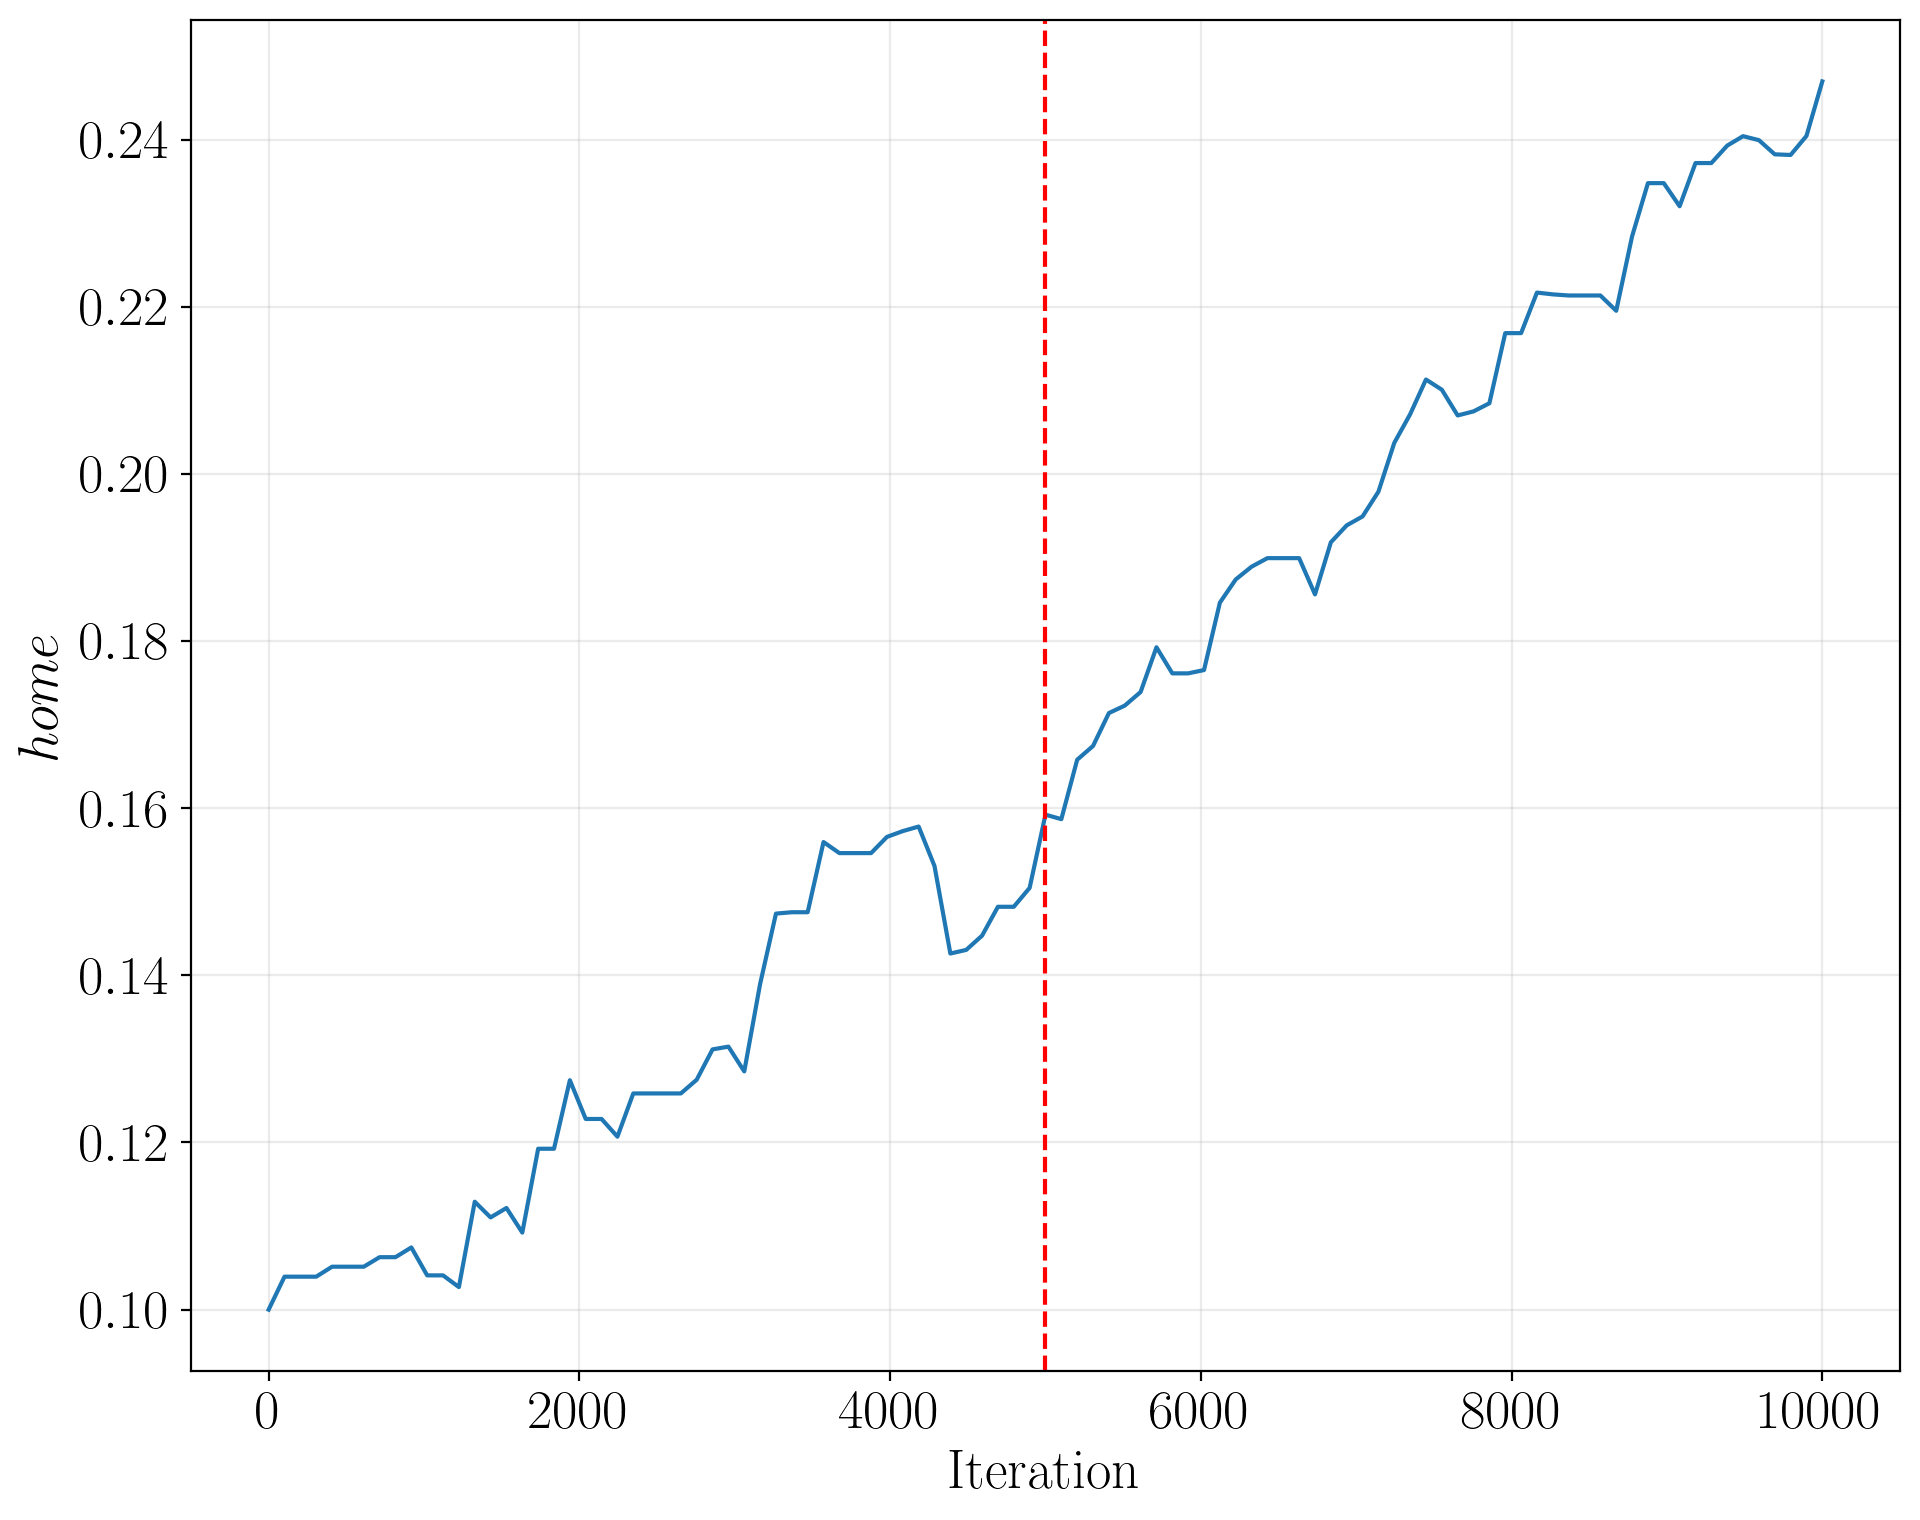

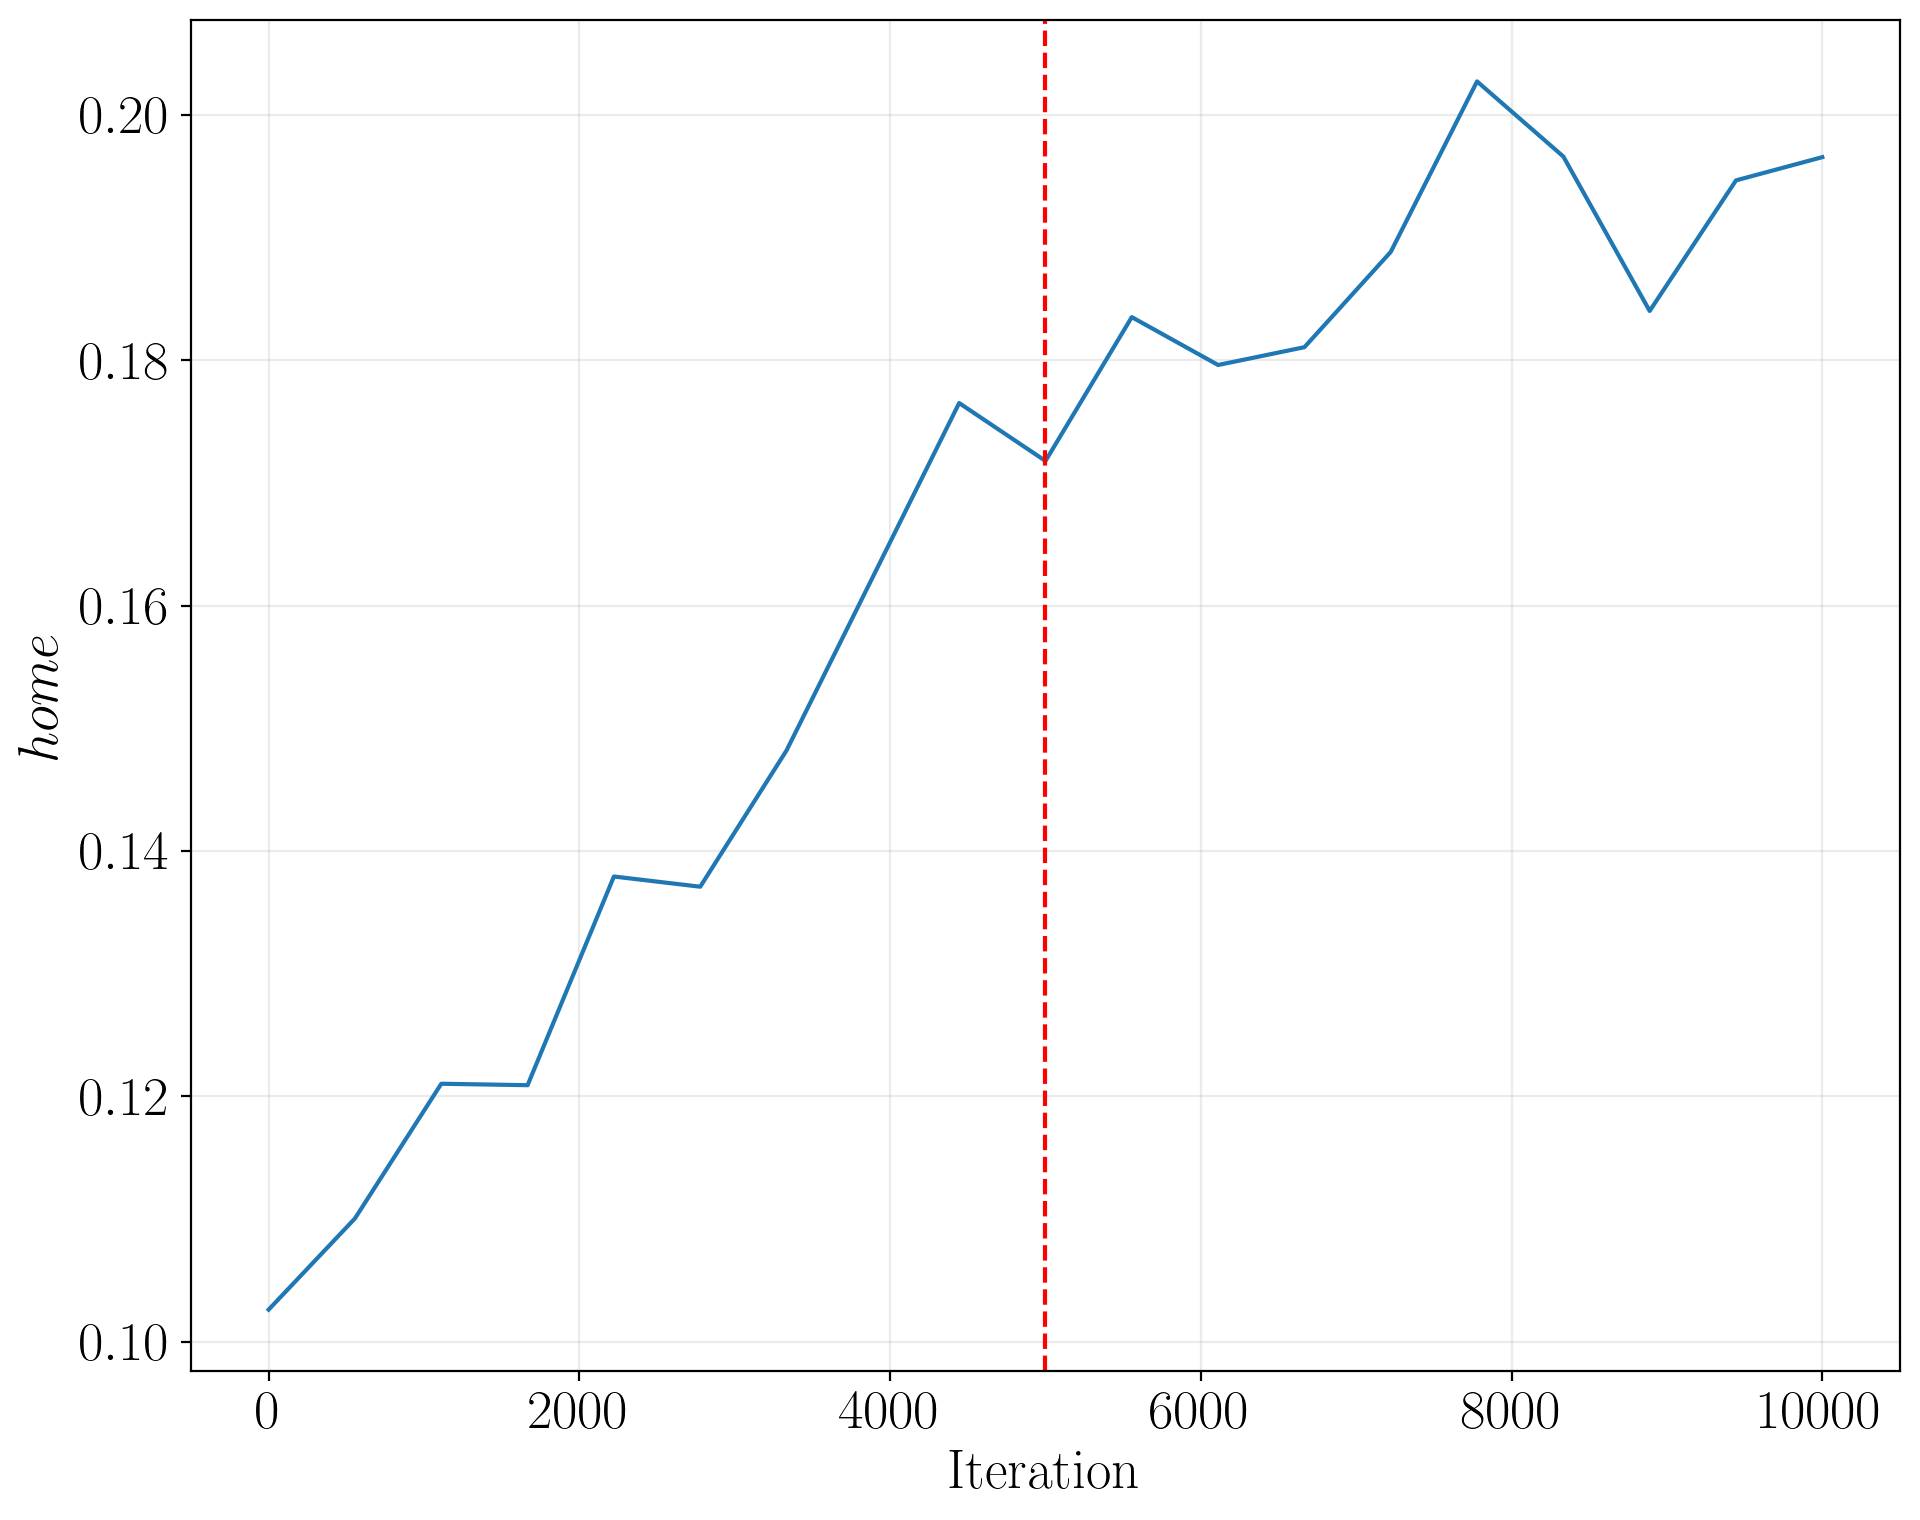

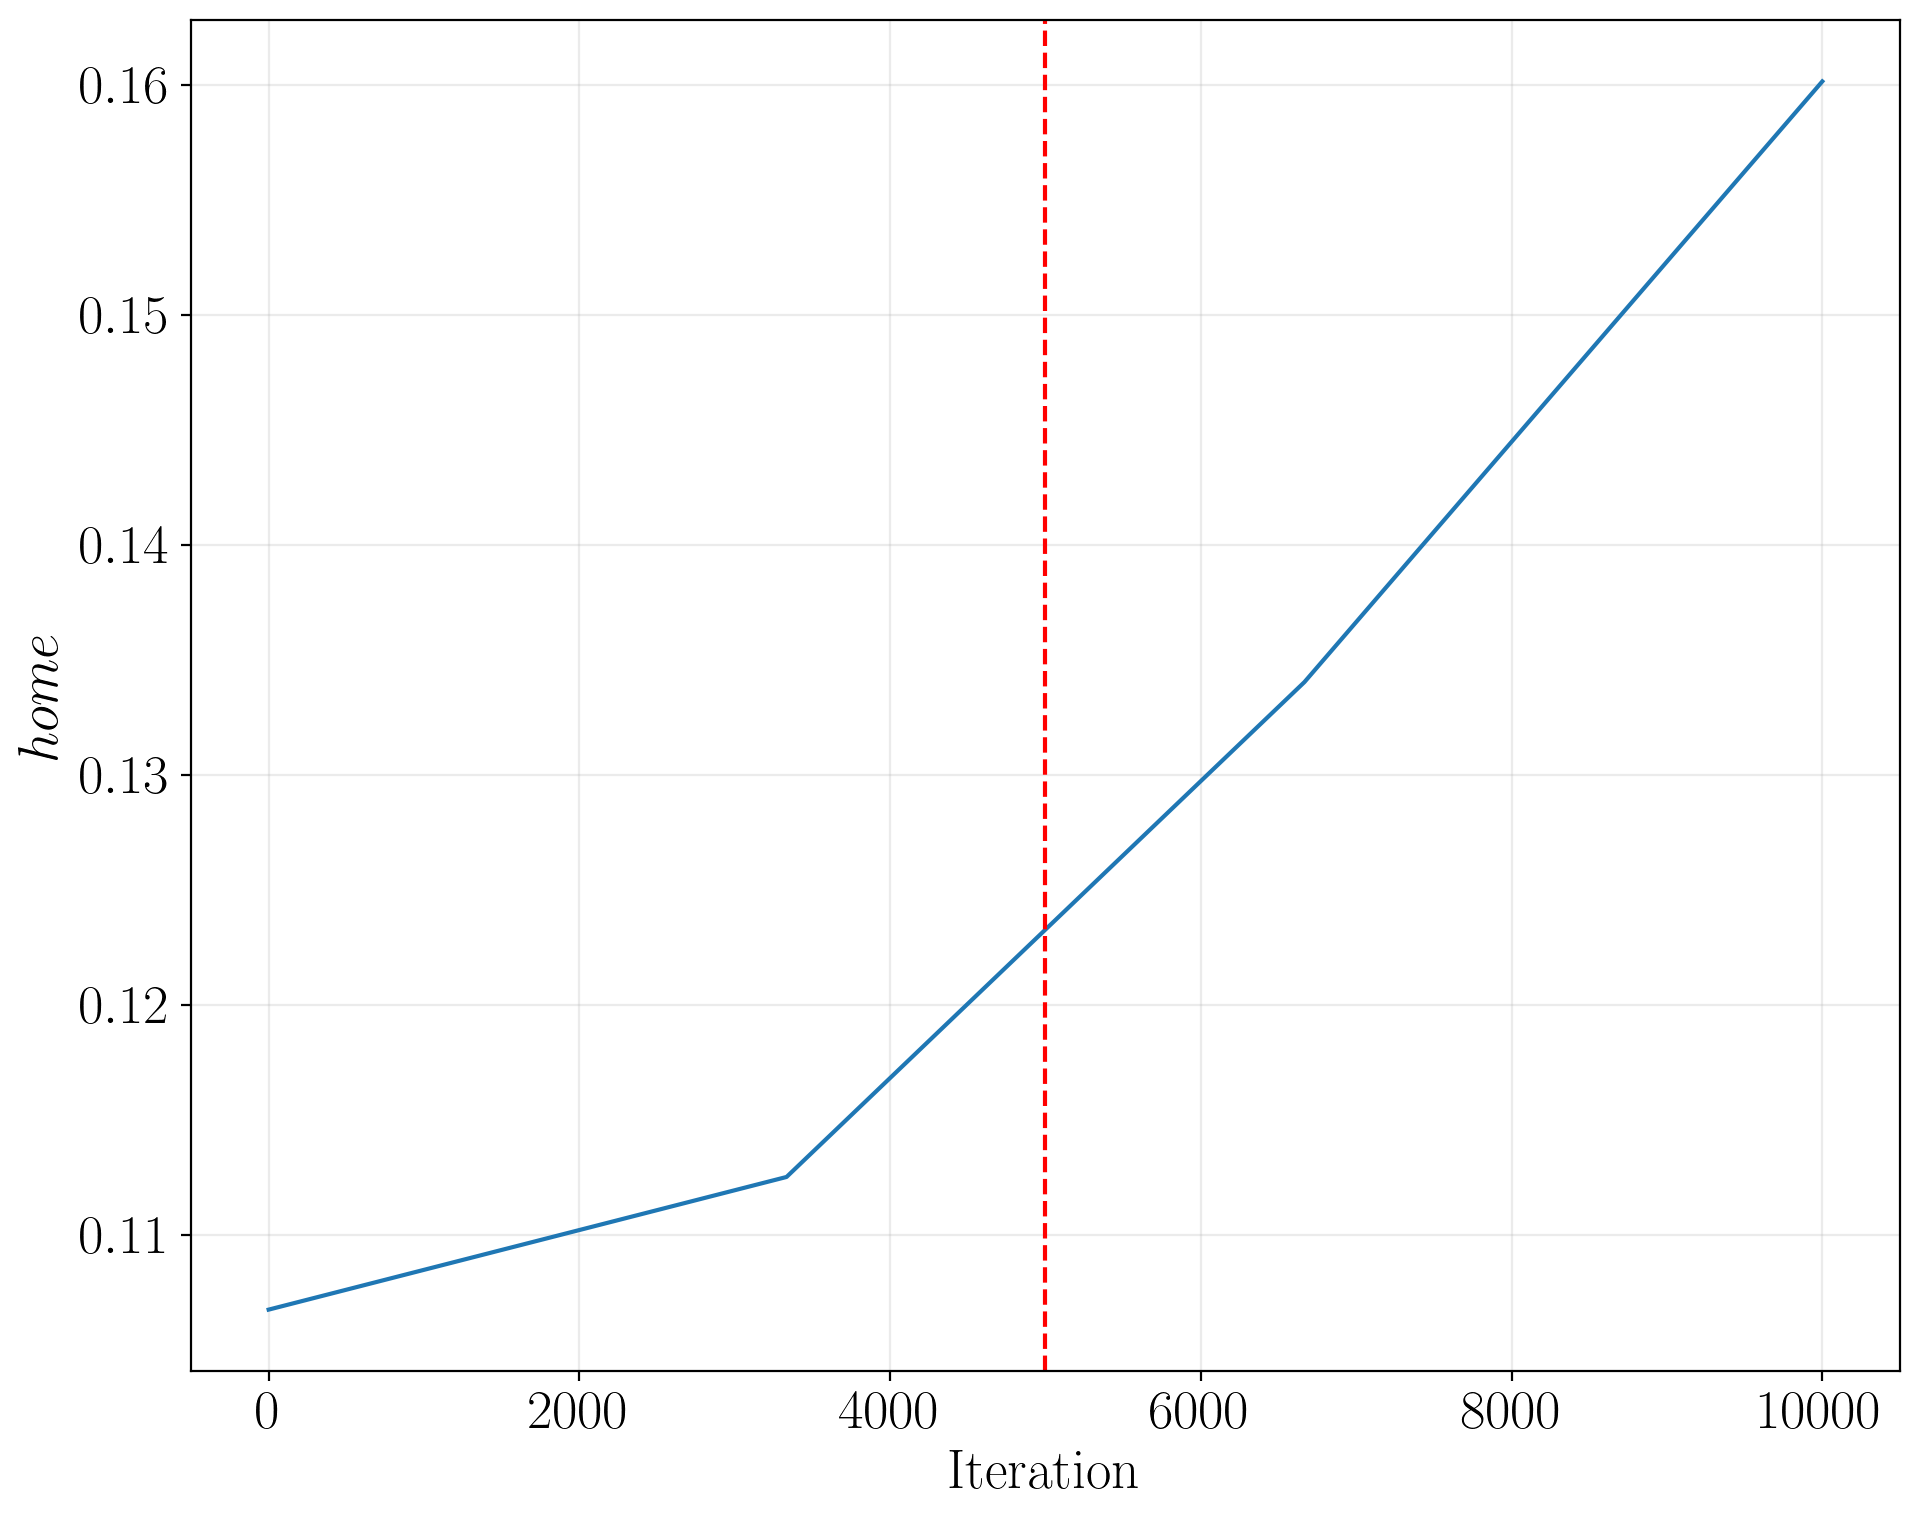

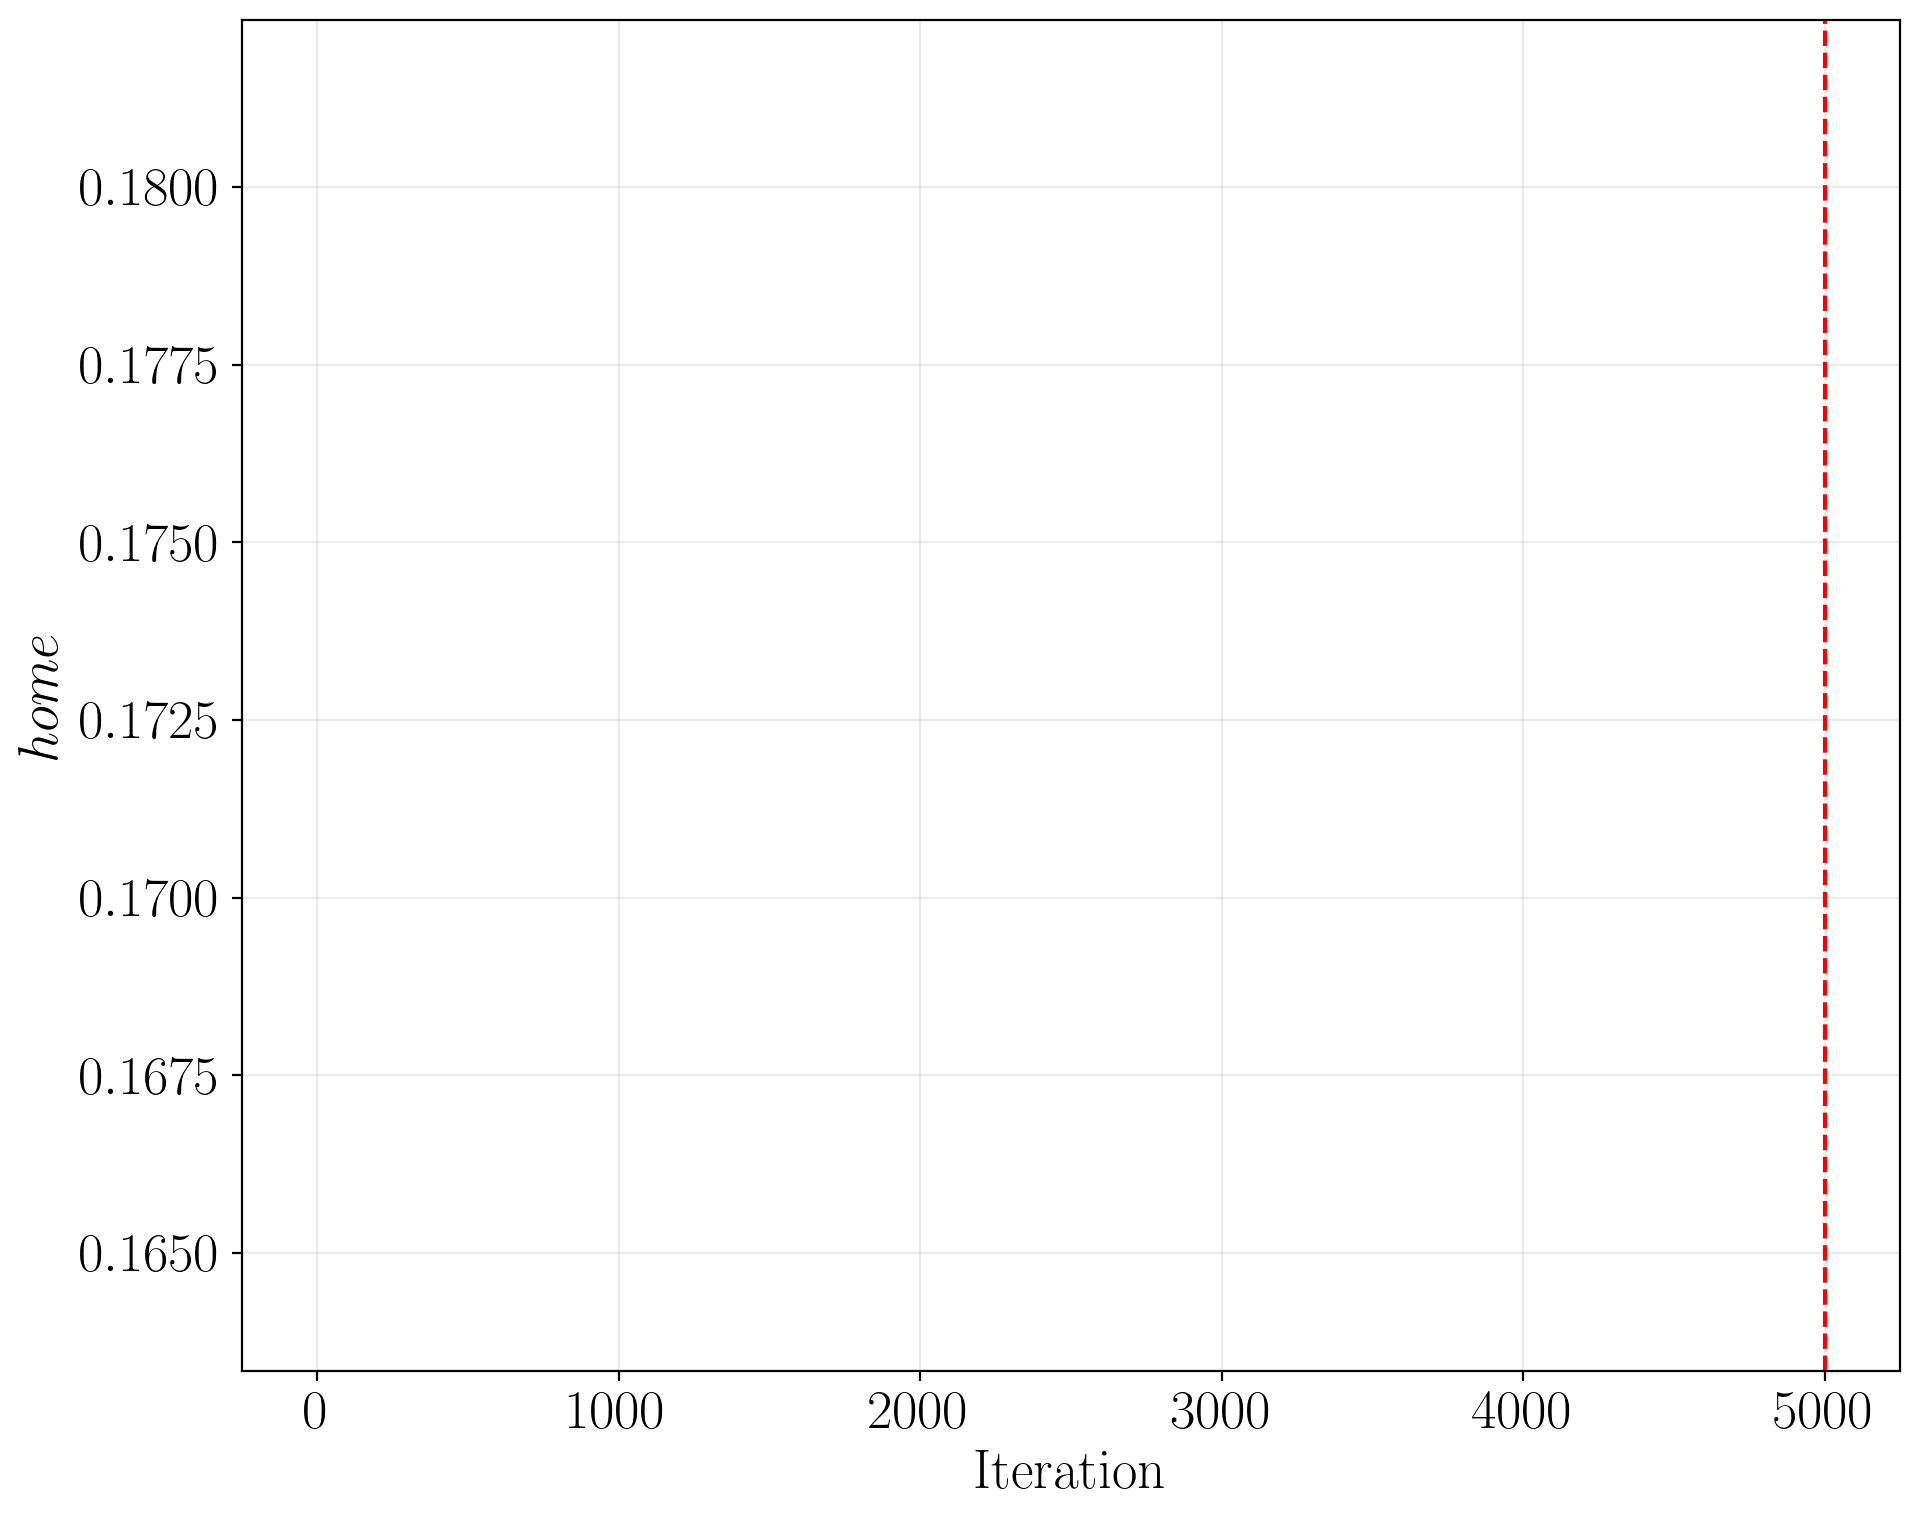

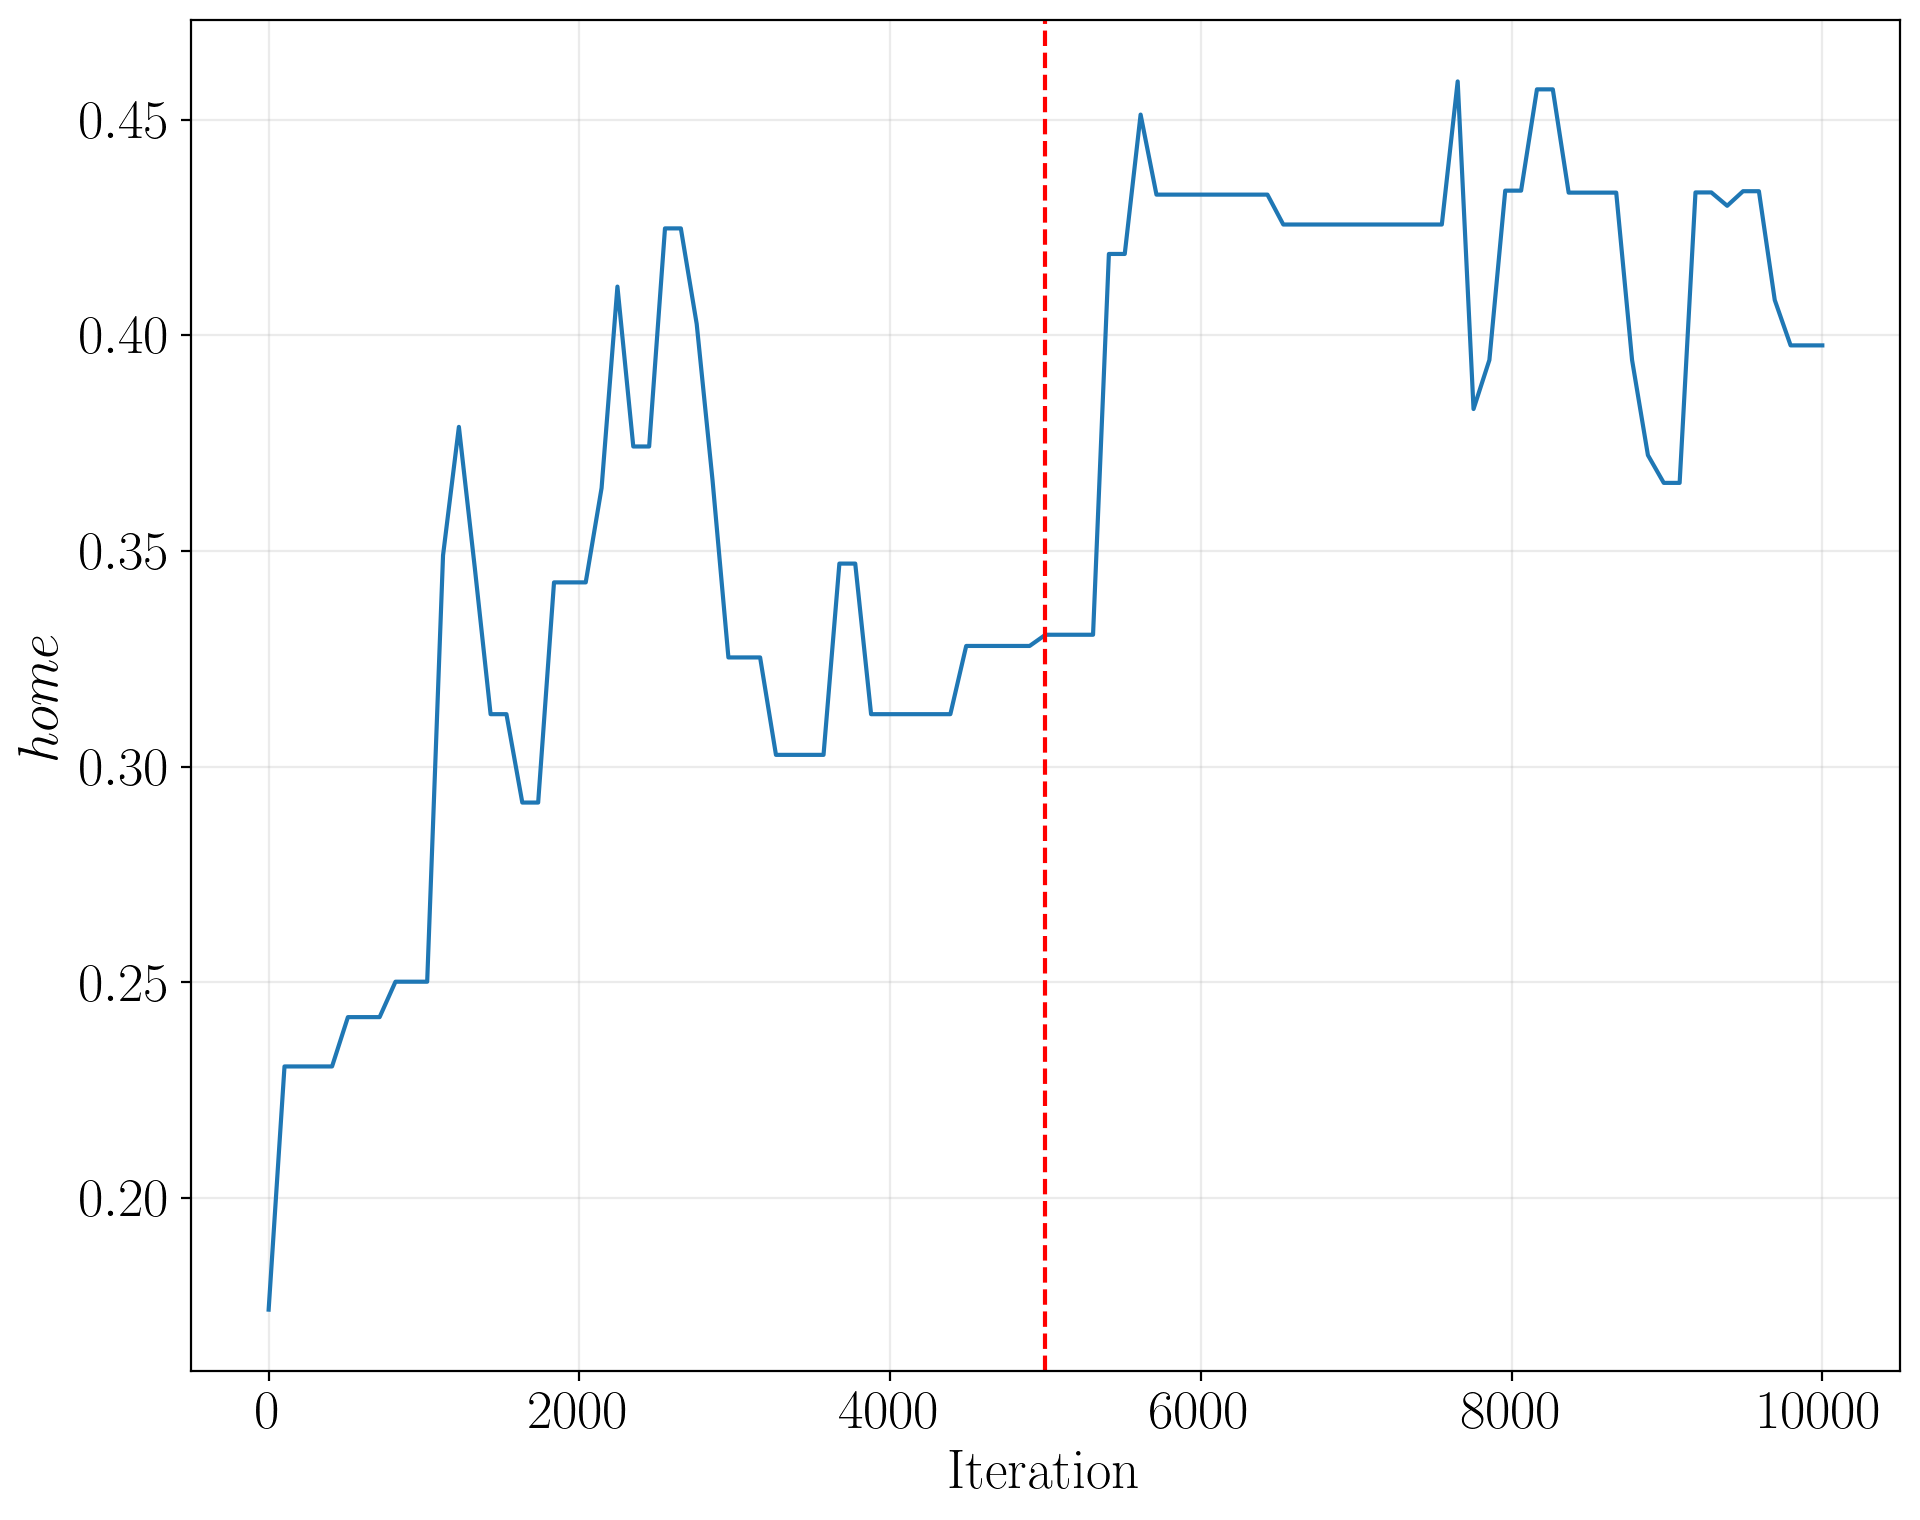

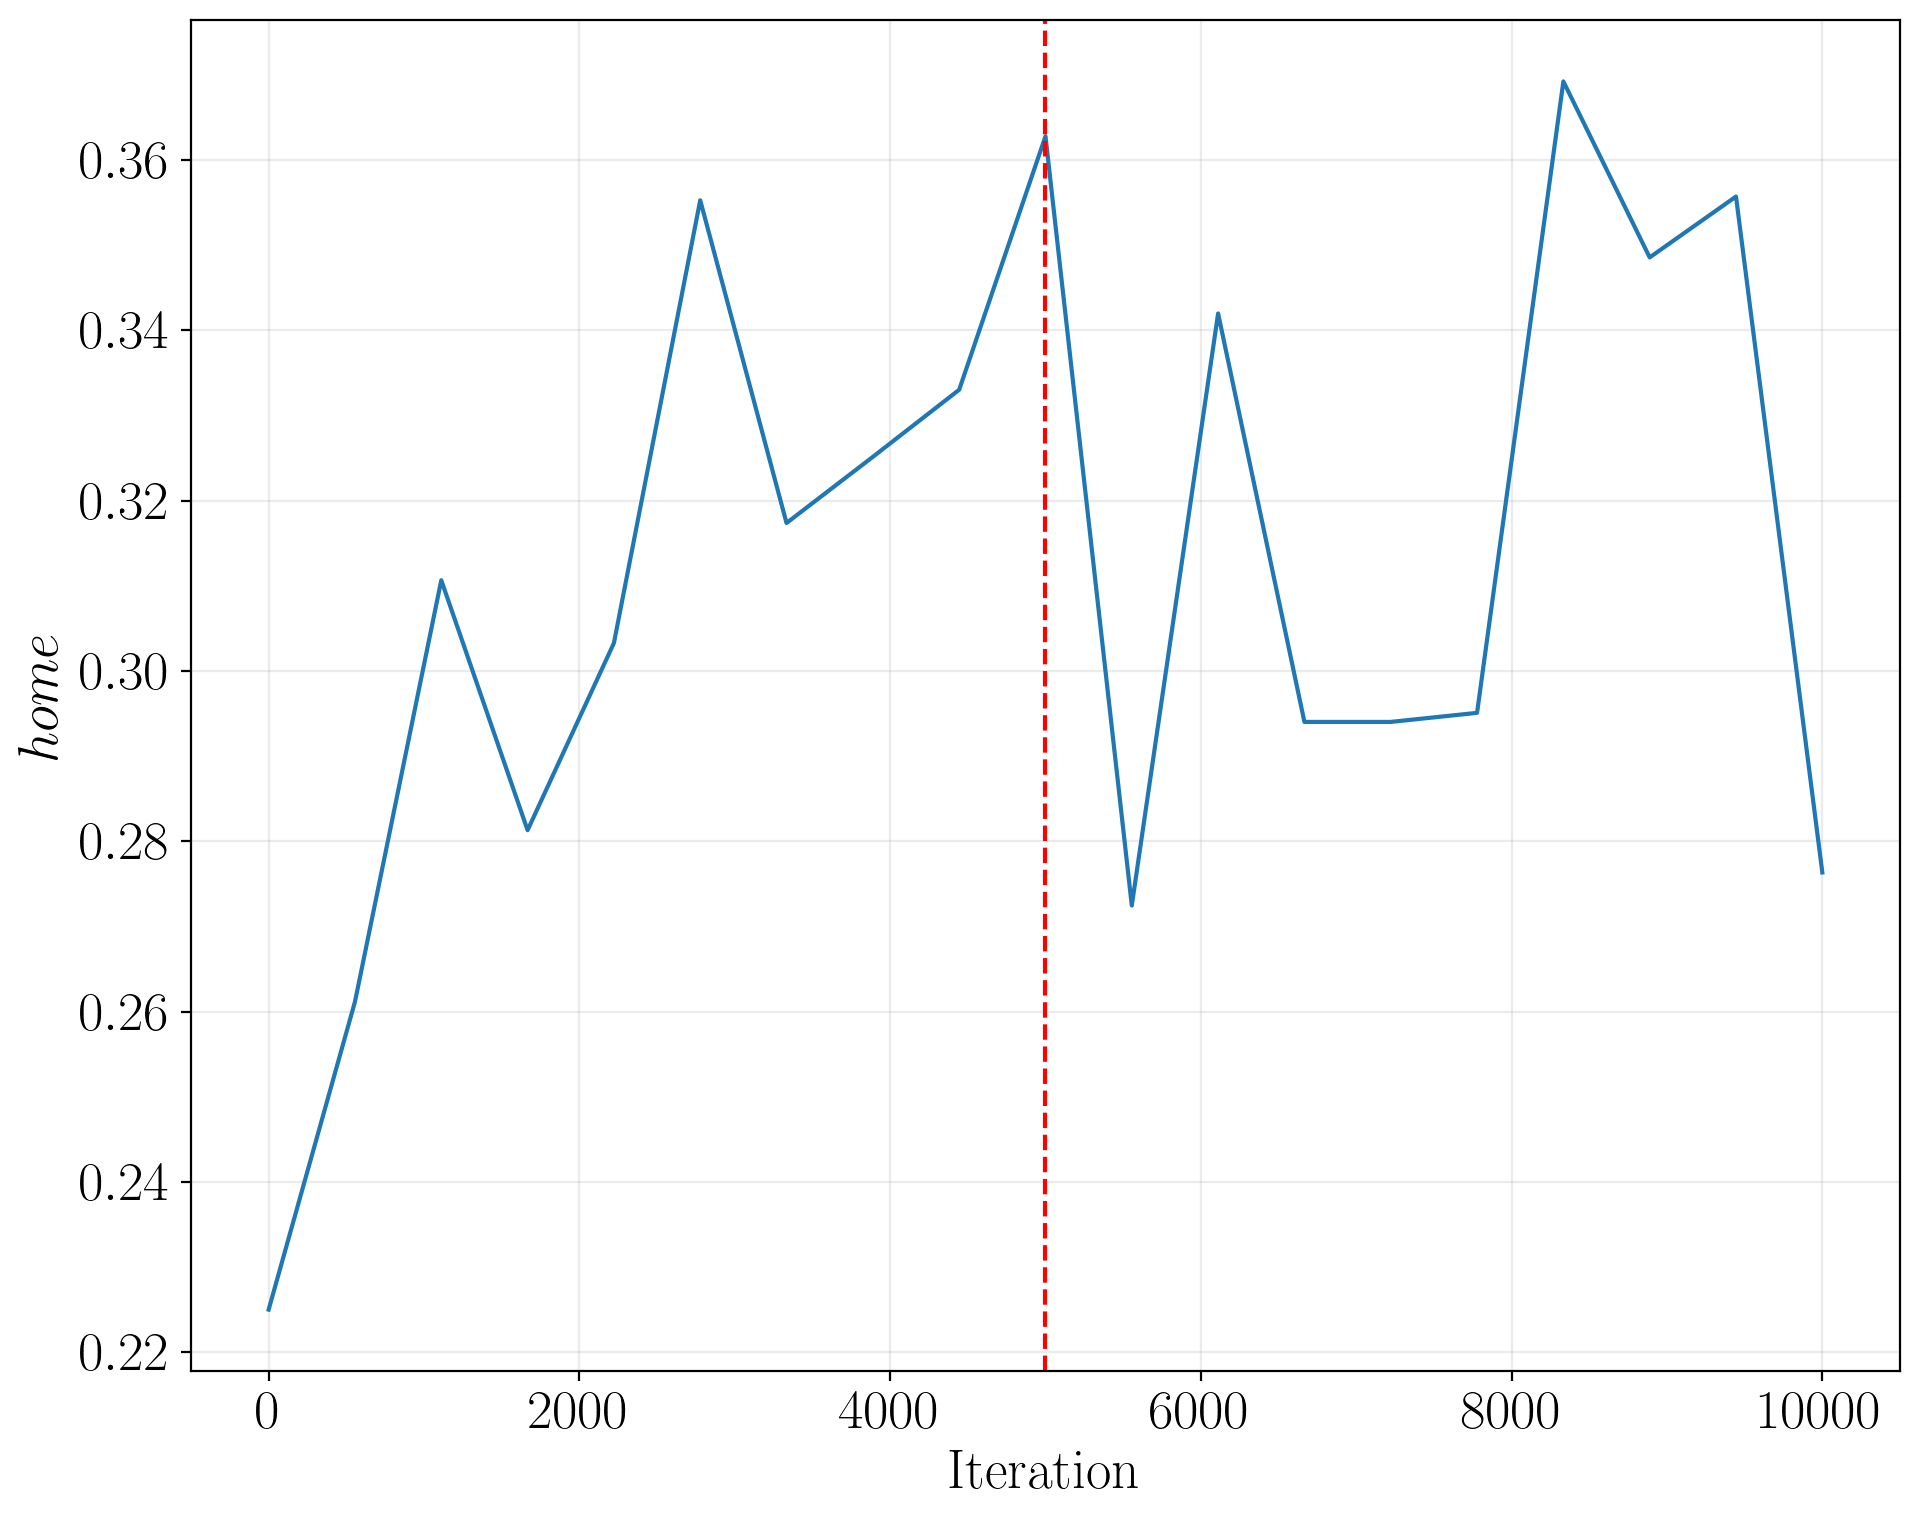

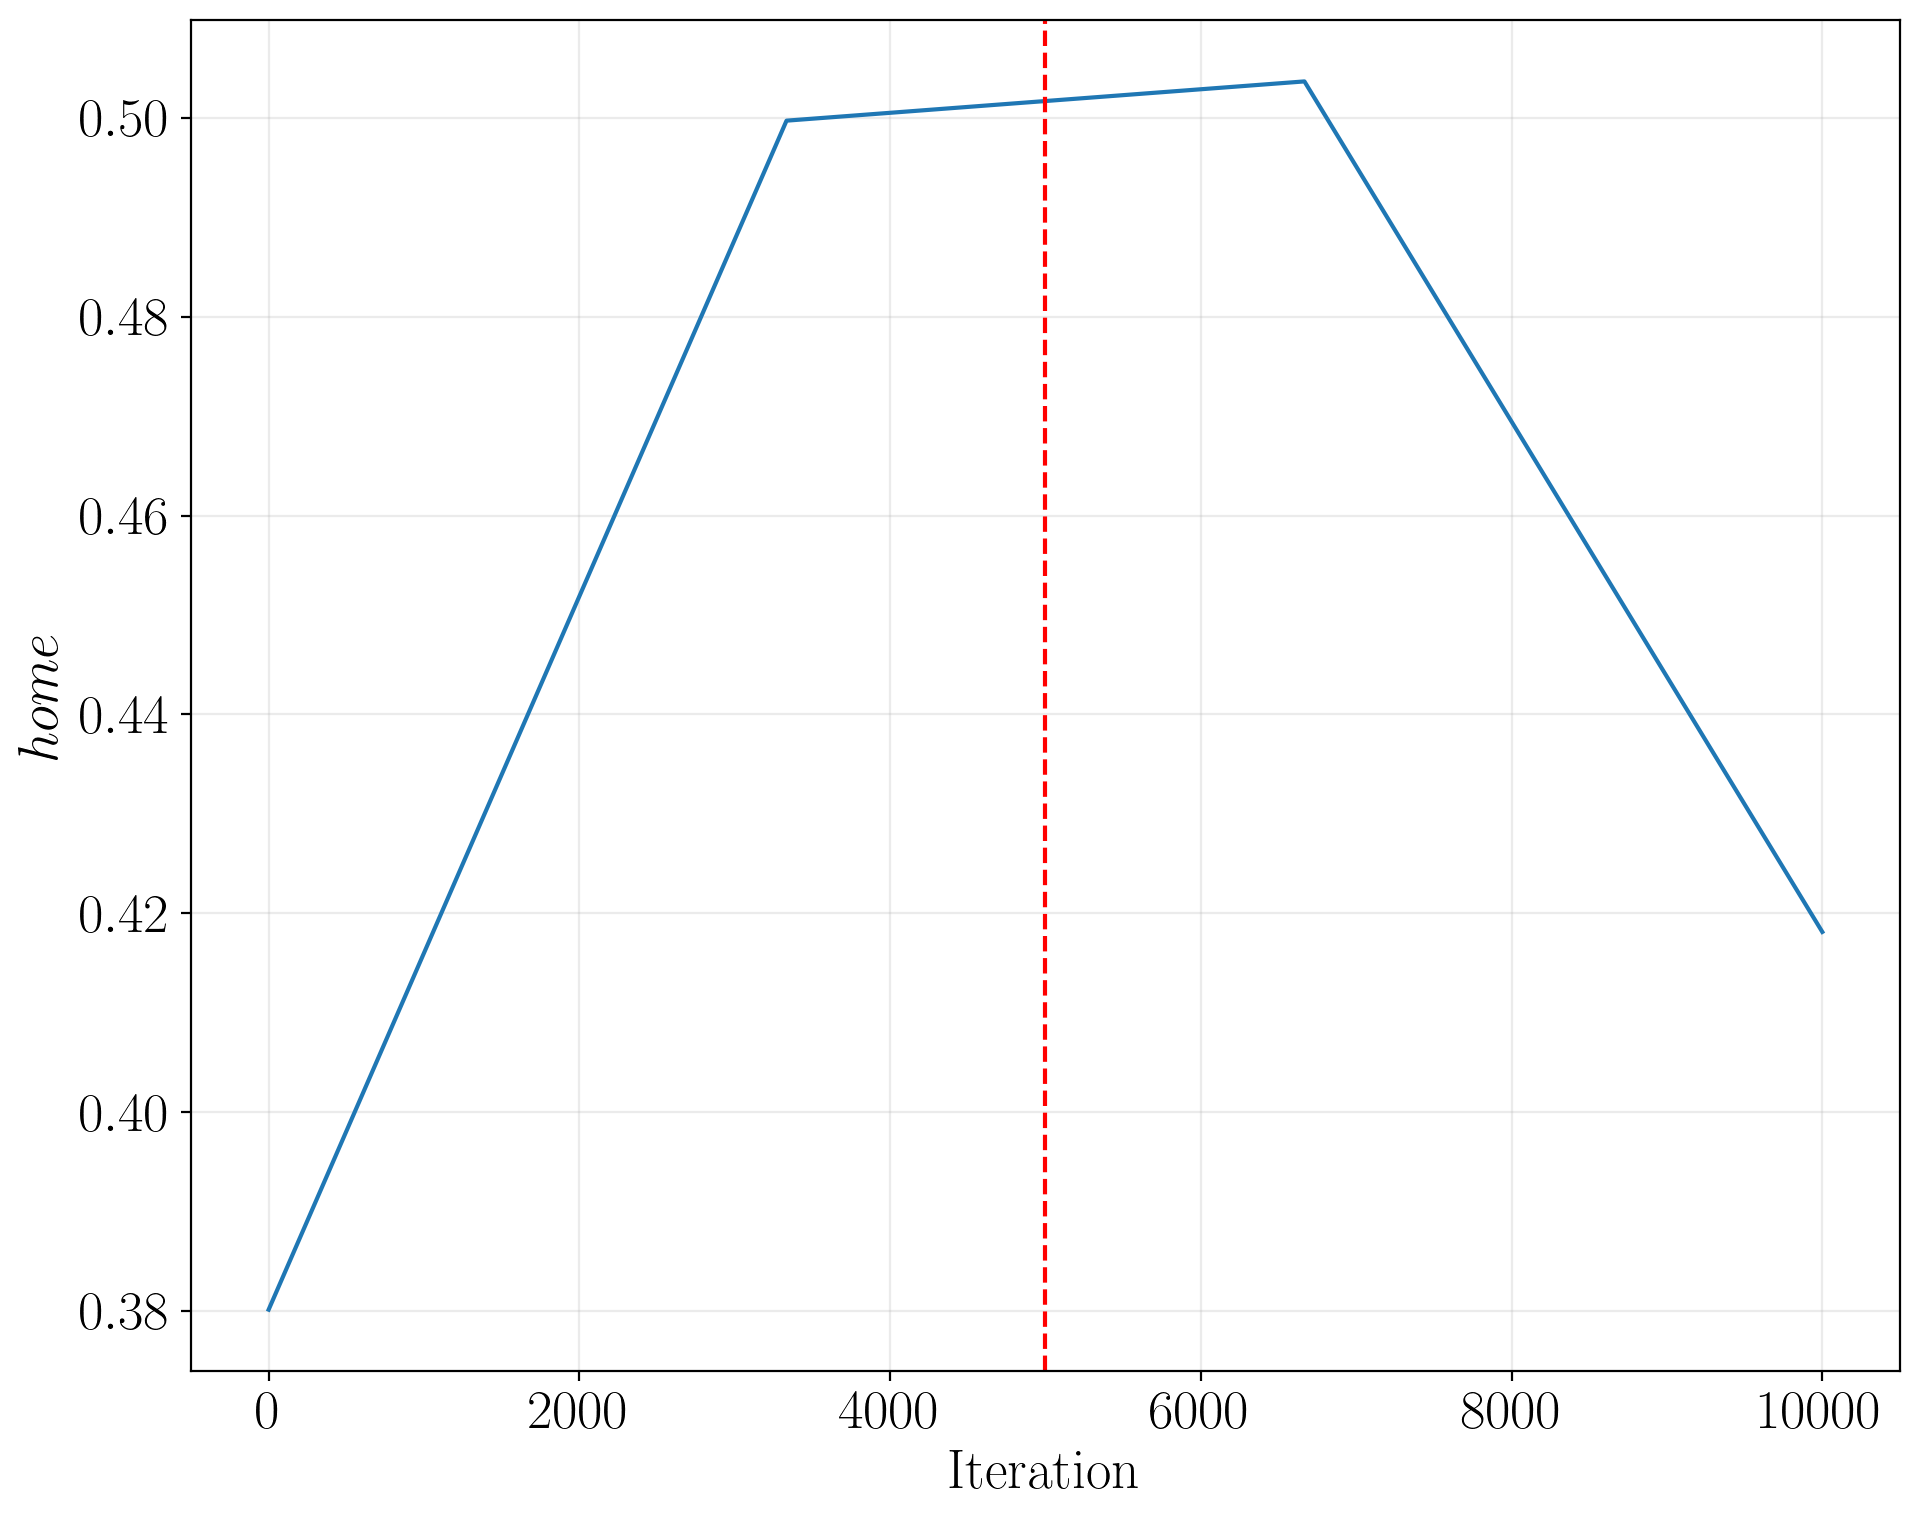

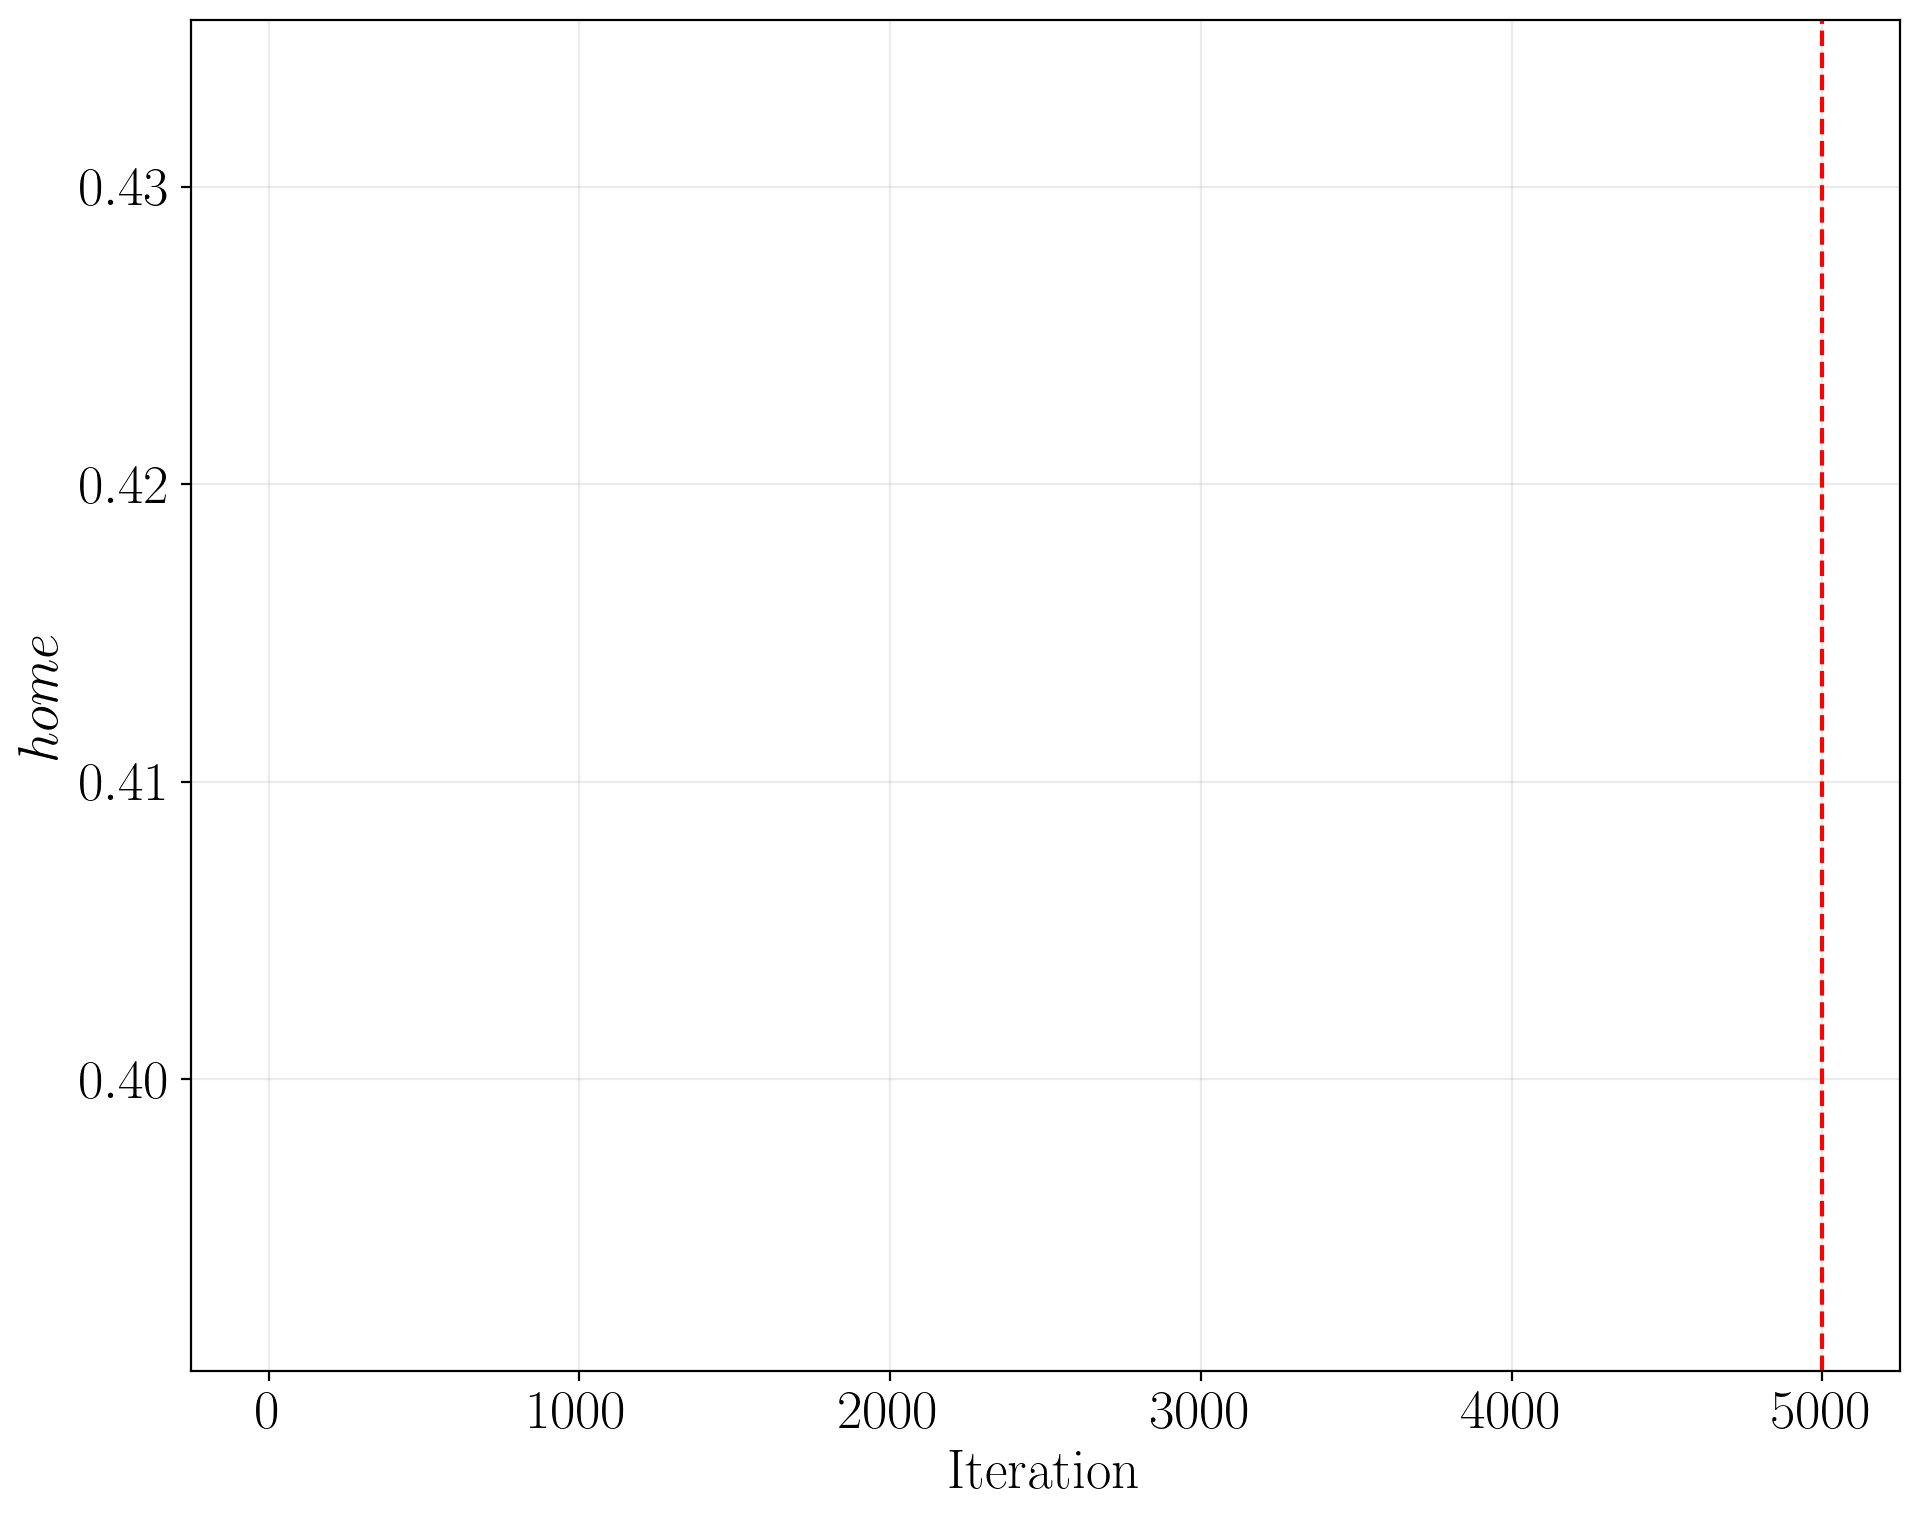

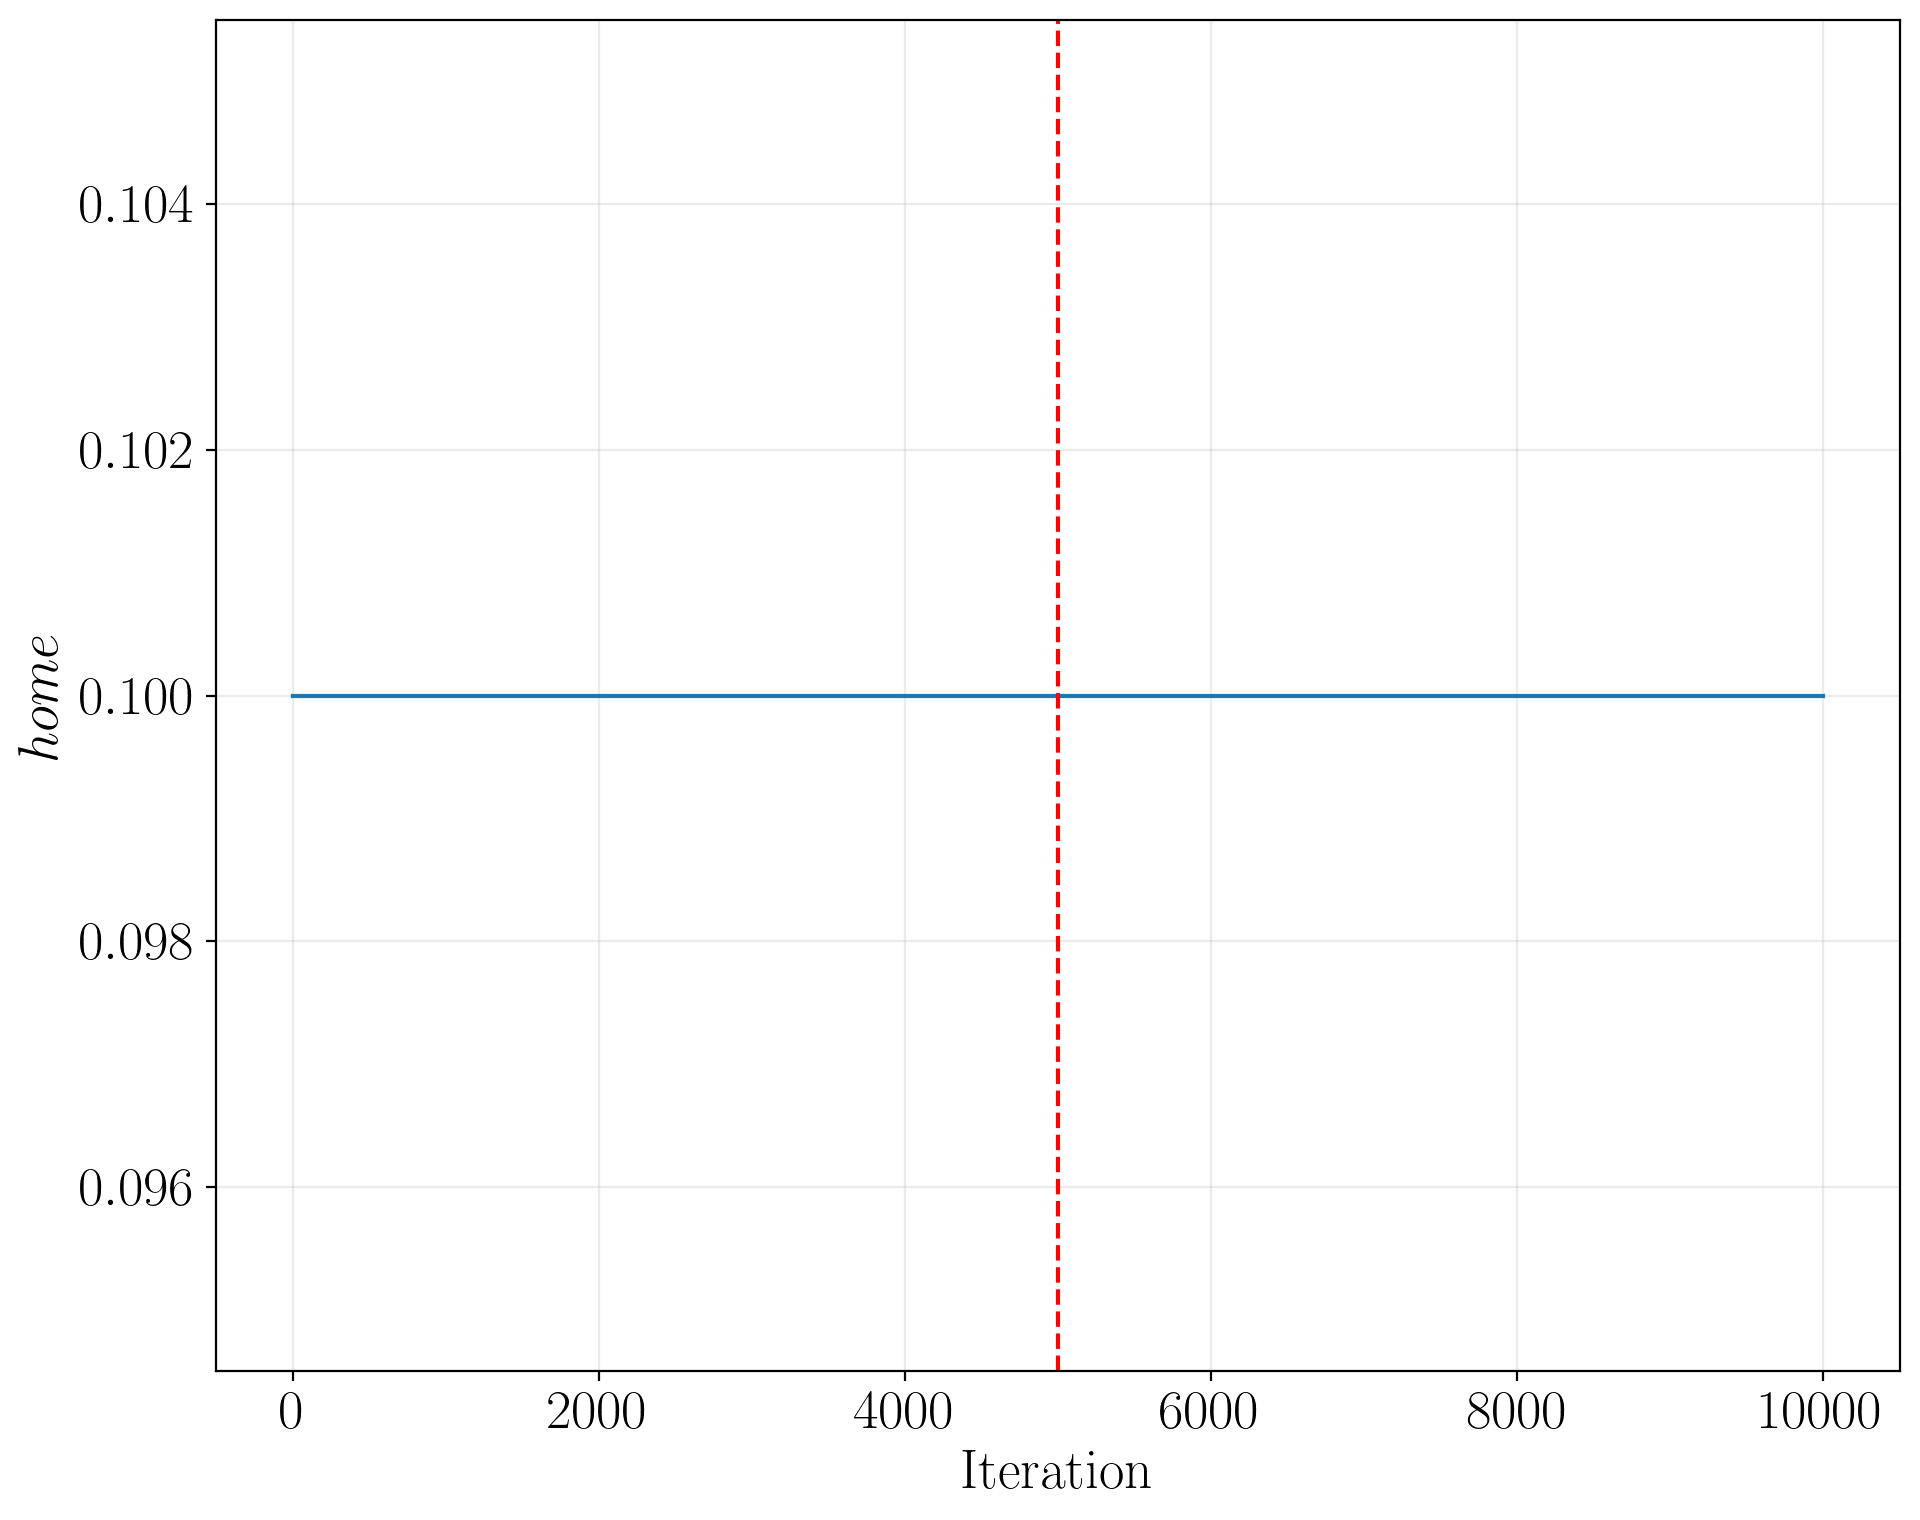

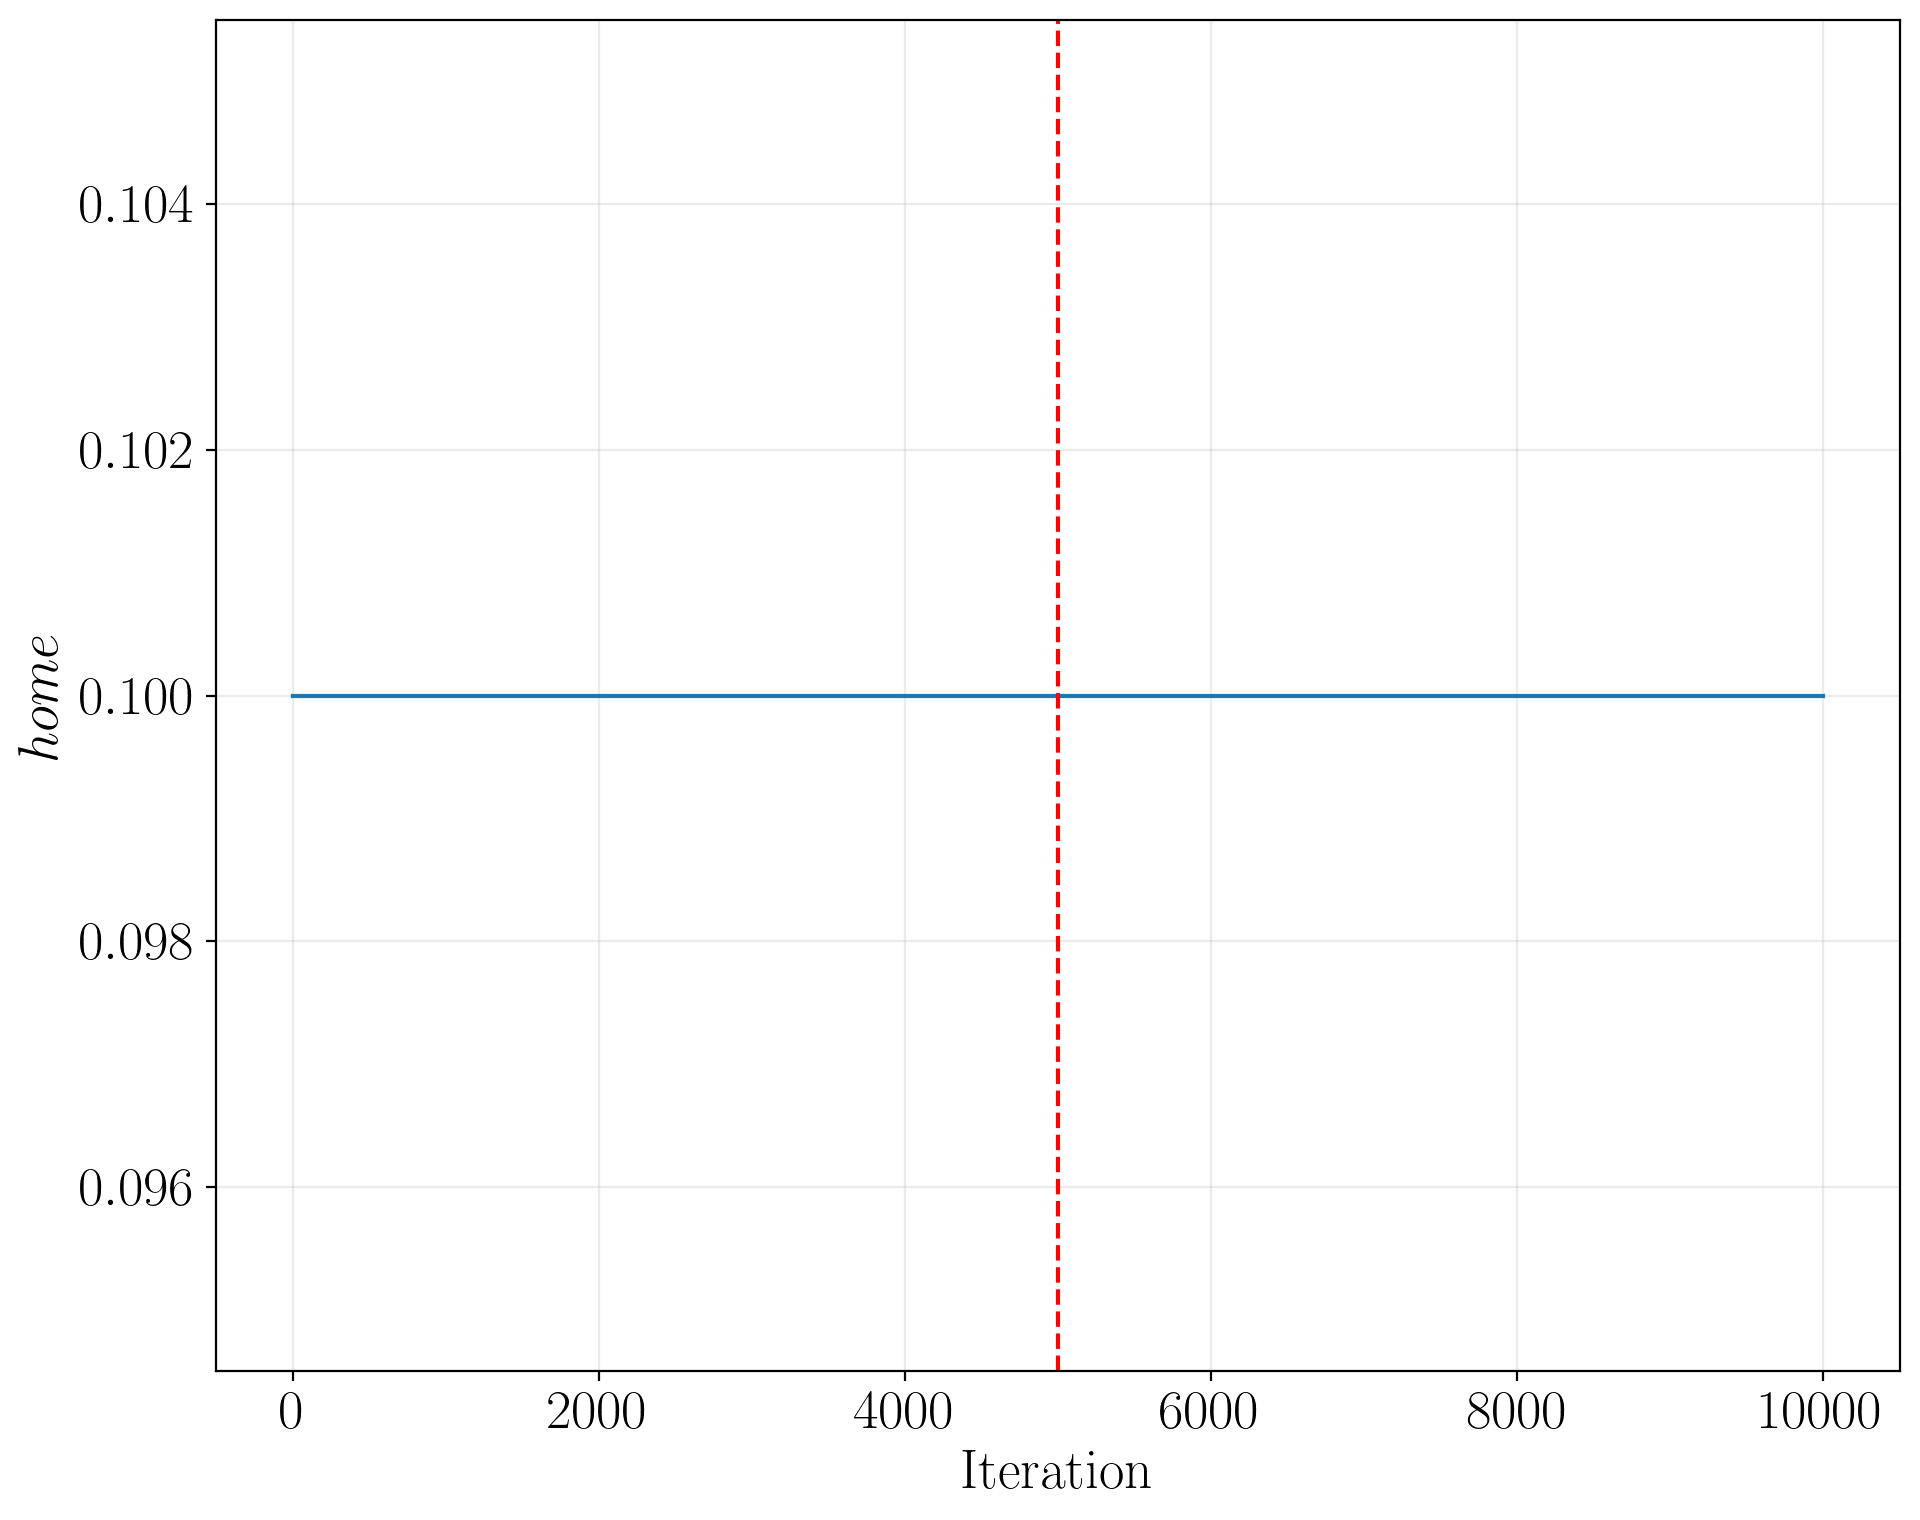

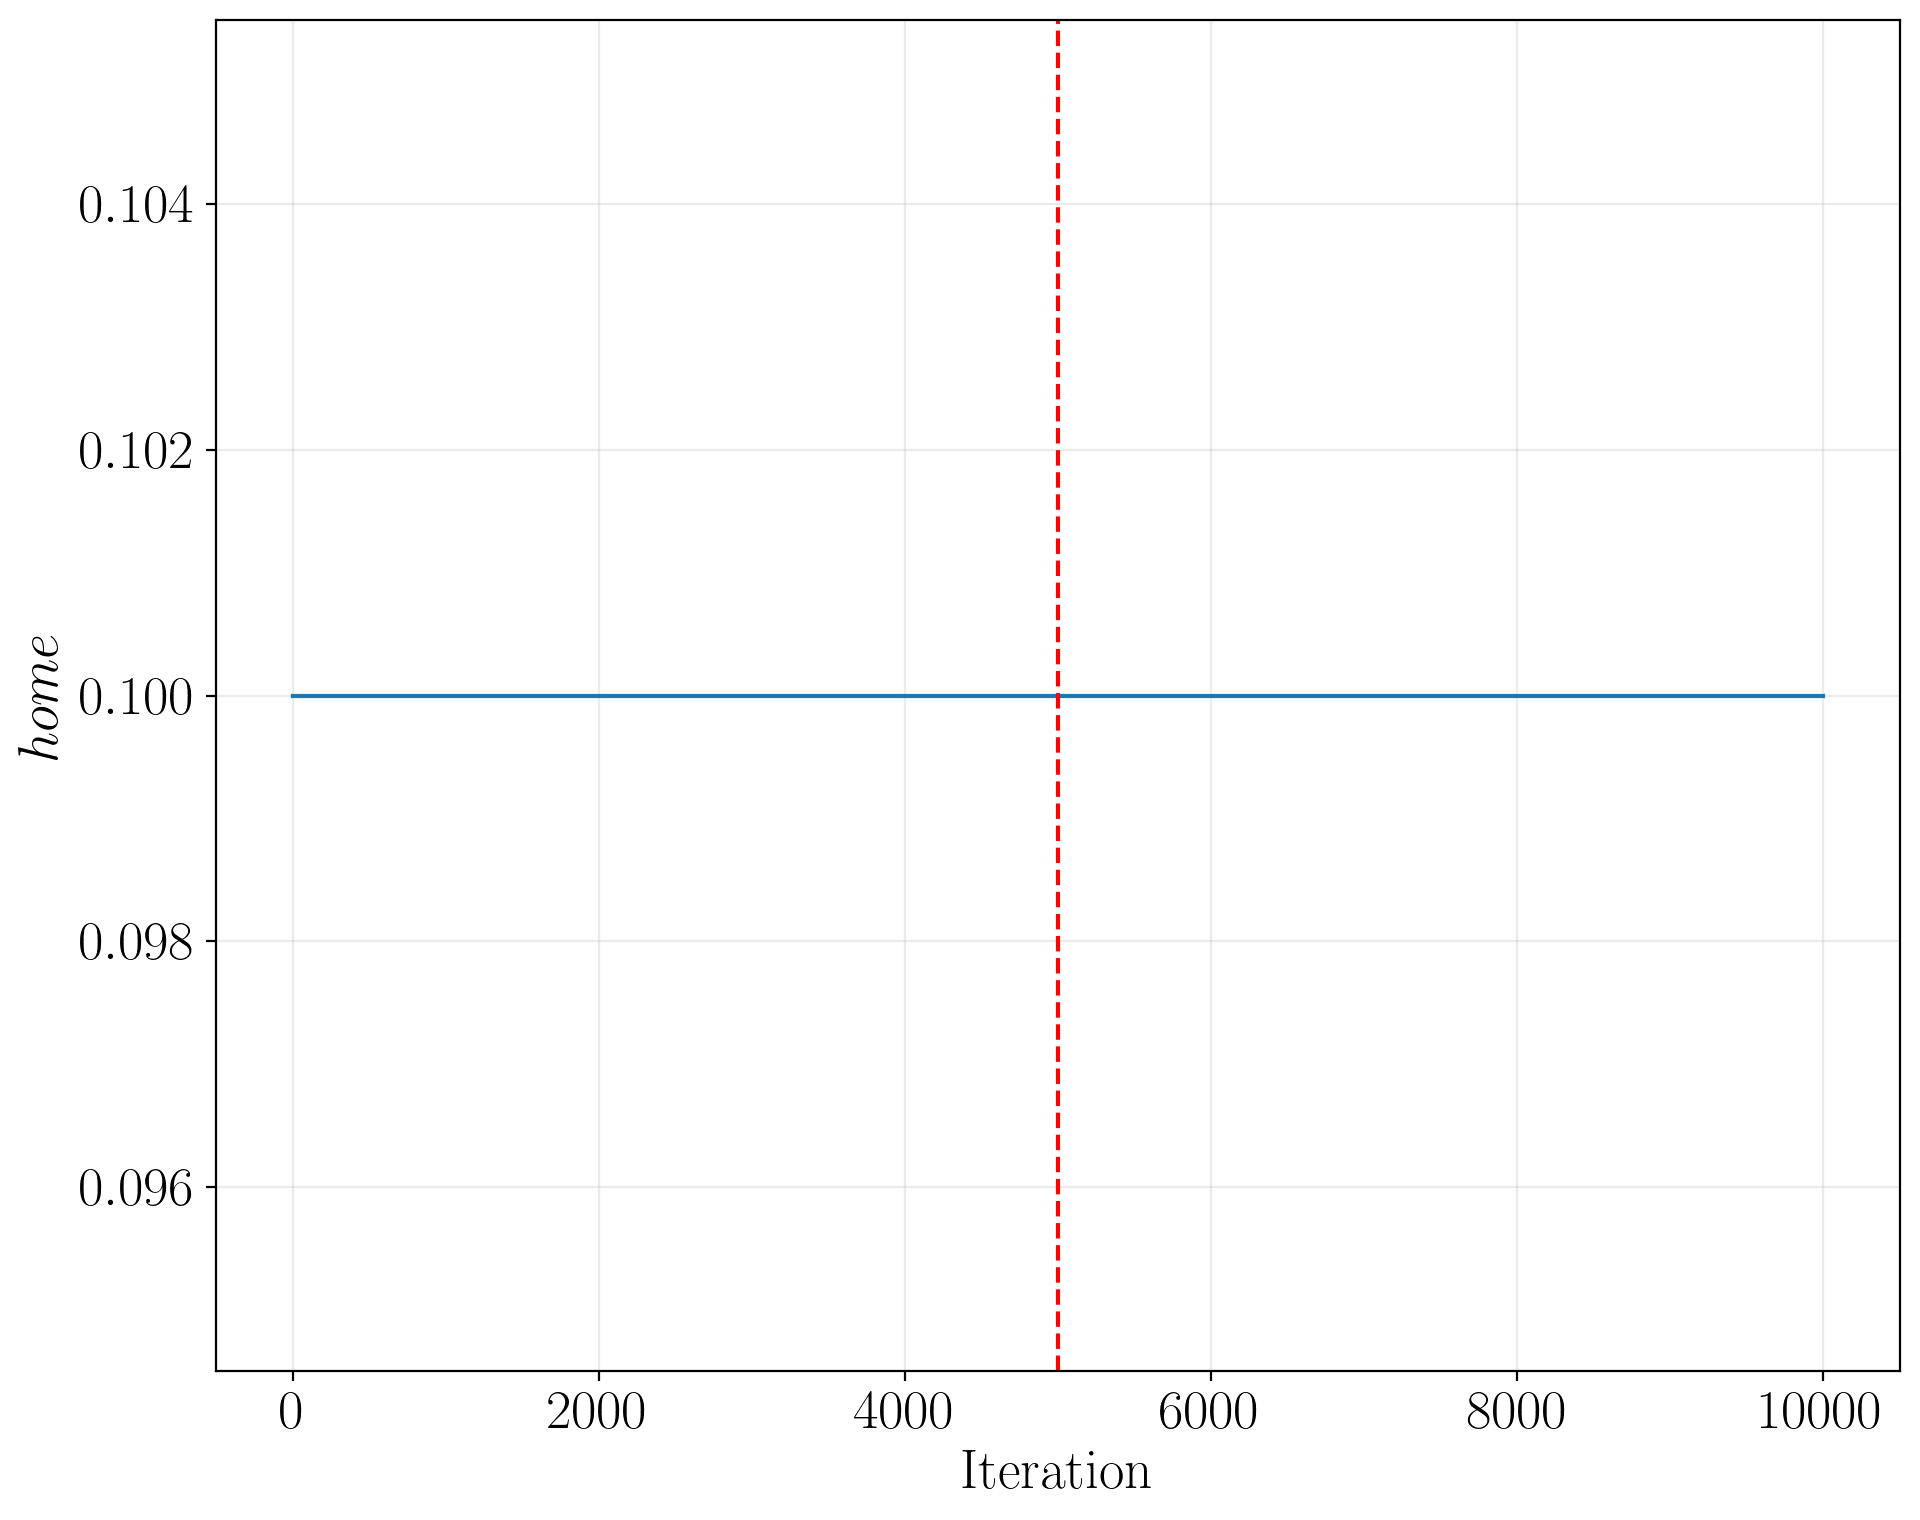

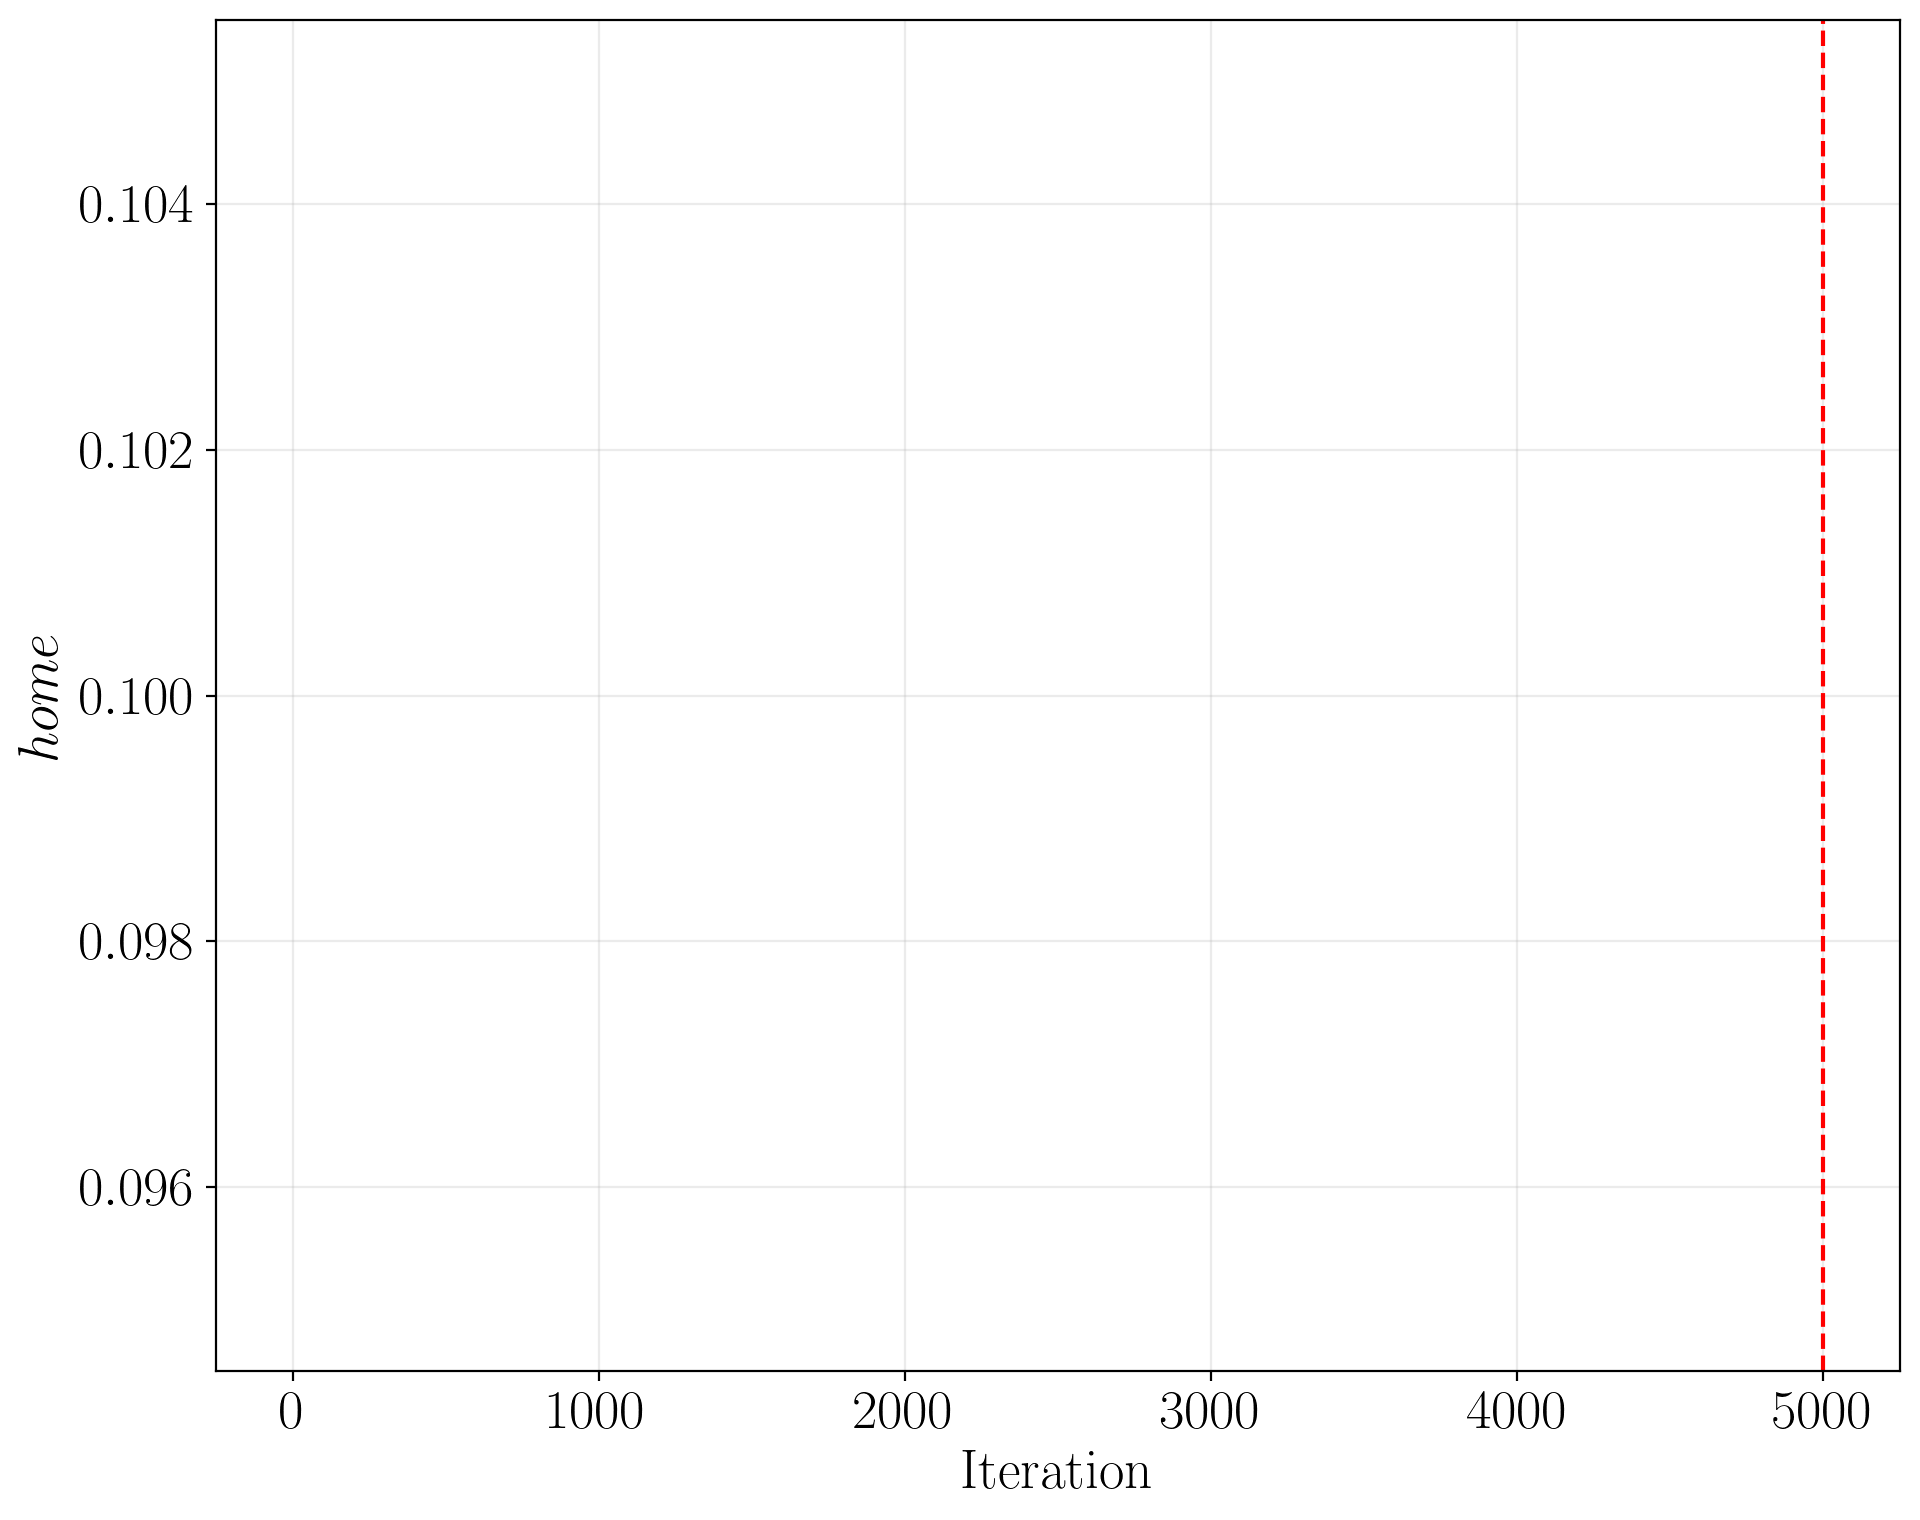

In [21]:
t = 0
for i in range(len(sigmas)):
    for j in range(len(thinning)):
        home = np.load(f'samples/home_sigma={sigmas[i]}_thinning={thinning[j]}.npy')
        home = home_batches[t]
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(np.array(np.linspace(0,10000,home.shape[0])), home, '-')
        ax.axvline(x=5000, color='red', linestyle='--', label='Burn-in')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('$home$')
        ax.grid(True, alpha=0.25)
        fig.tight_layout()
        # fig.savefig(f'report-images/home_sigma={sigmas[i]}_thinning={thinning[j]}.png', dpi=300)
        plt.show()
        t += 1

In [22]:
t = 0
for i in range(len(sigmas)):
    for j in range(len(thinning)):
        rejection = np.load(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy')
        rejection = rejection_batches[t]
        rejection = rejection[5000:]
        print(f'Rejection rate: sigma={sigmas[i]}, thinning={thinning[j]}:', np.mean(rejection), len(rejection))
        t += 1

Rejection rate: sigma=0.005, thinning=1: nan 0
Rejection rate: sigma=0.005, thinning=5: nan 0
Rejection rate: sigma=0.005, thinning=20: nan 0
Rejection rate: sigma=0.005, thinning=50: nan 0
Rejection rate: sigma=0.05, thinning=1: nan 0
Rejection rate: sigma=0.05, thinning=5: nan 0
Rejection rate: sigma=0.05, thinning=20: nan 0
Rejection rate: sigma=0.05, thinning=50: nan 0
Rejection rate: sigma=0.5, thinning=1: nan 0
Rejection rate: sigma=0.5, thinning=5: nan 0
Rejection rate: sigma=0.5, thinning=20: nan 0
Rejection rate: sigma=0.5, thinning=50: nan 0


c:\Users\erikn\skola\venv_chalmers\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\erikn\skola\venv_chalmers\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [233]:
n_its = 10000
sigmas = [0.005, 0.05, 0.5]
thinning = [1, 5, 20, 50]
burn_in = 5000
samples, rejection = metropolis_hastings(n_its, sigmas[1], dataf, thinning[1], burn_in)
samples = np.array(samples)

  0%|          | 4/10000 [00:00<21:10,  7.87it/s]C:\Users\erikn\AppData\Local\Temp\ipykernel_1160\2402202893.py:35: RuntimeWarning: invalid value encountered in sqrt
  attack_logprob = st.norm(mu_attack, 1/np.sqrt(tau_attack)).logpdf(attack)
100%|██████████| 10000/10000 [08:35<00:00, 19.40it/s]


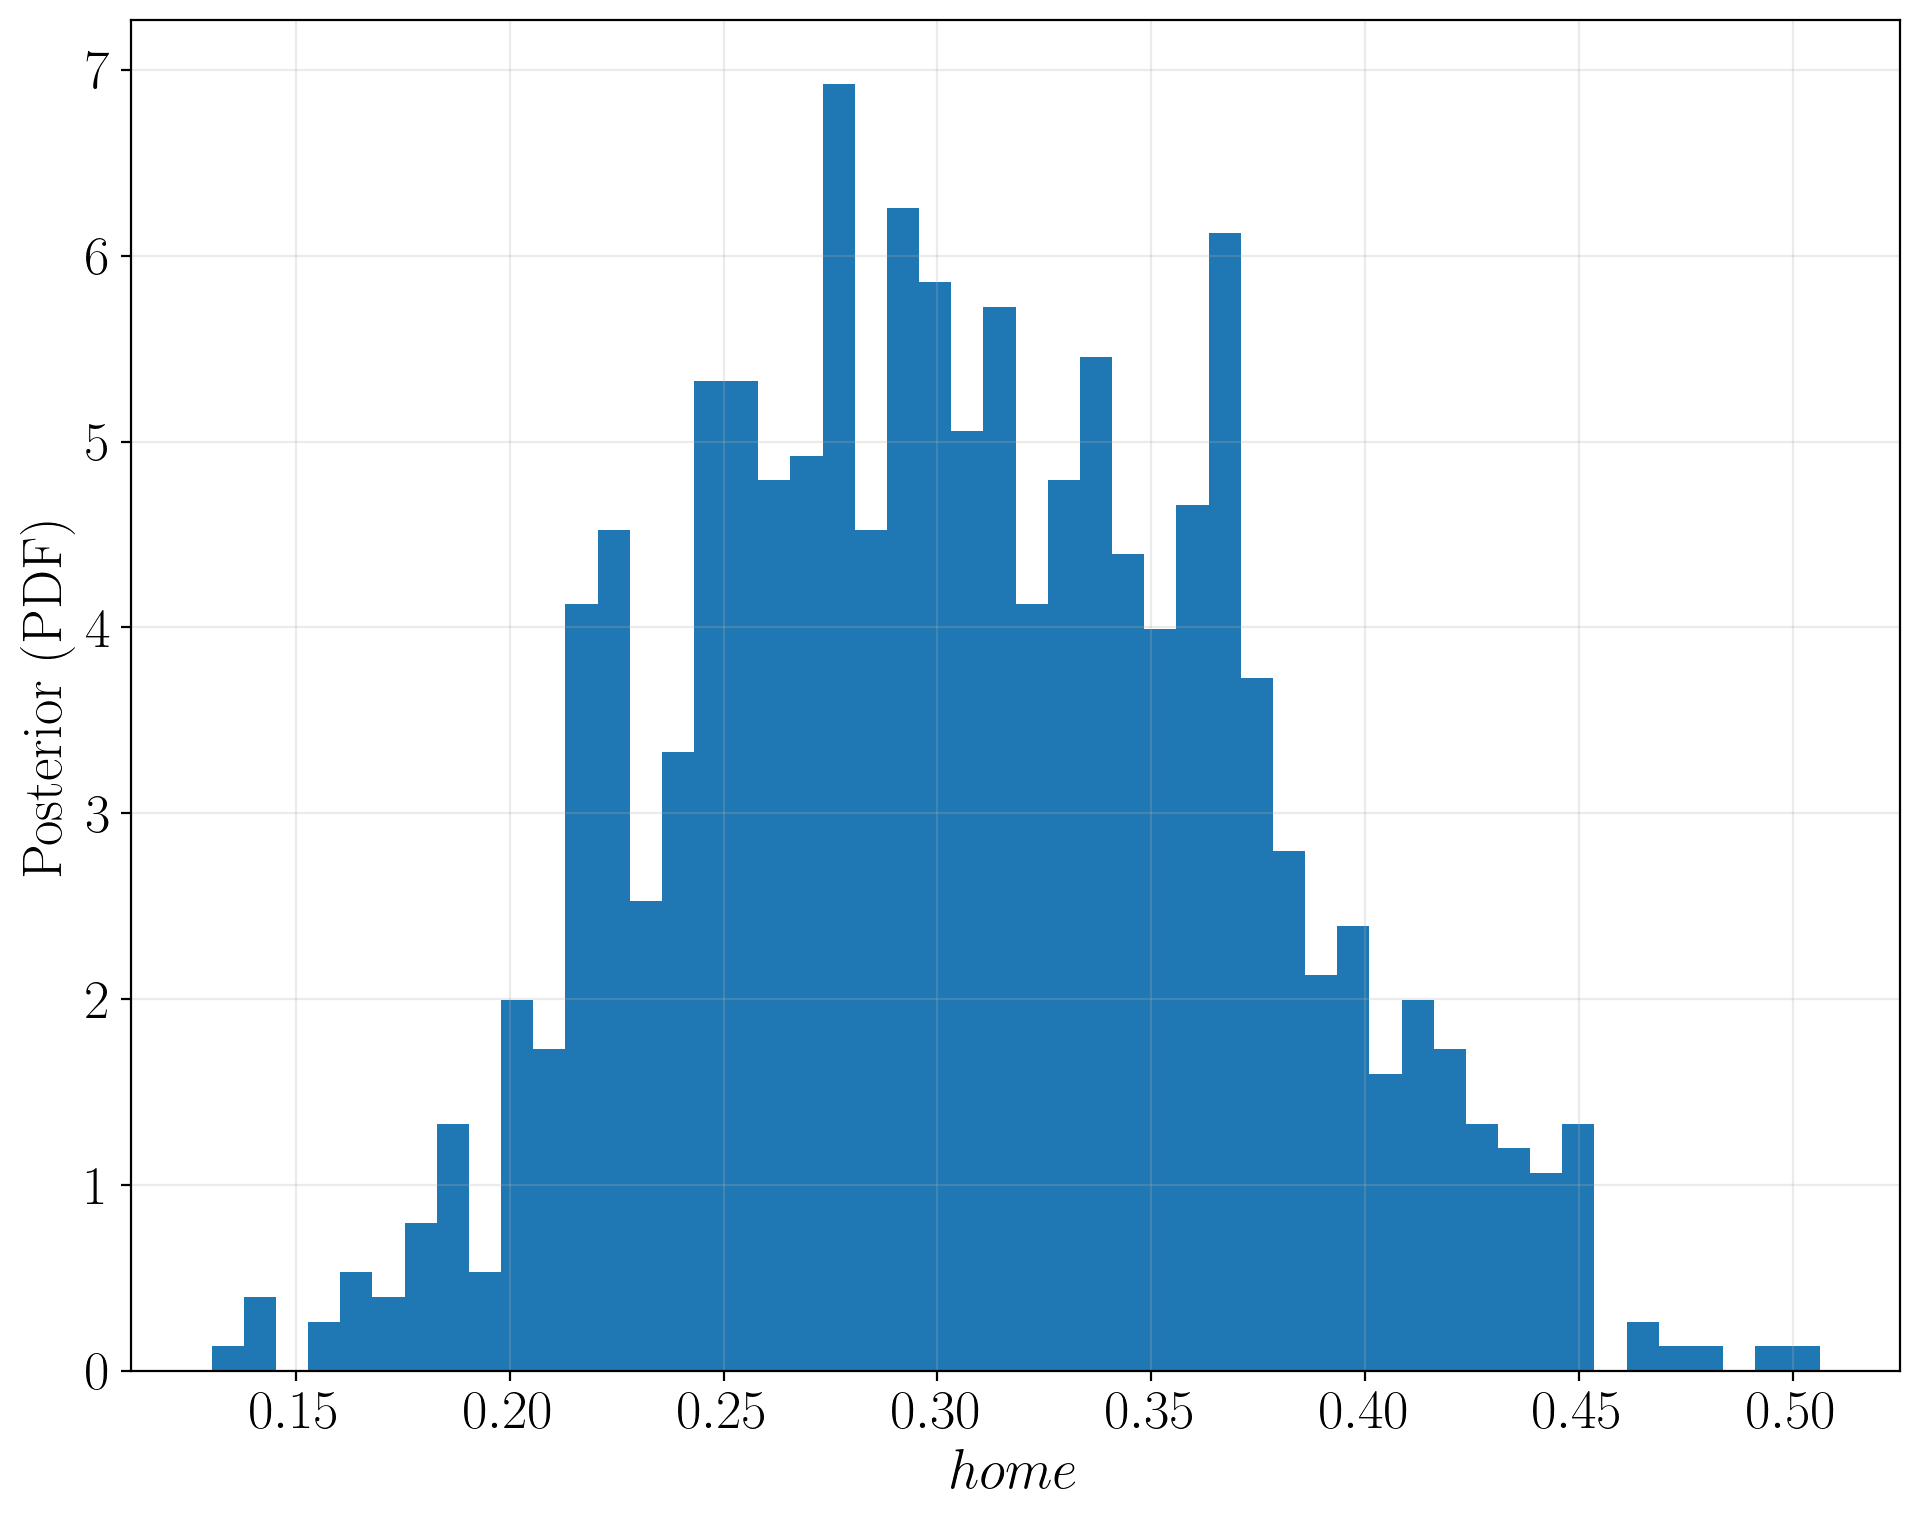

In [237]:
home = samples[:,-1]

fig = plt.figure()
plt.hist(home, bins=50, density=True)
plt.xlabel('$home$')
plt.ylabel('Posterior (PDF)')
plt.grid(True, alpha=0.25)
fig.tight_layout()
# fig.savefig(f'report-images/home_hist.png', dpi=300)
plt.show()

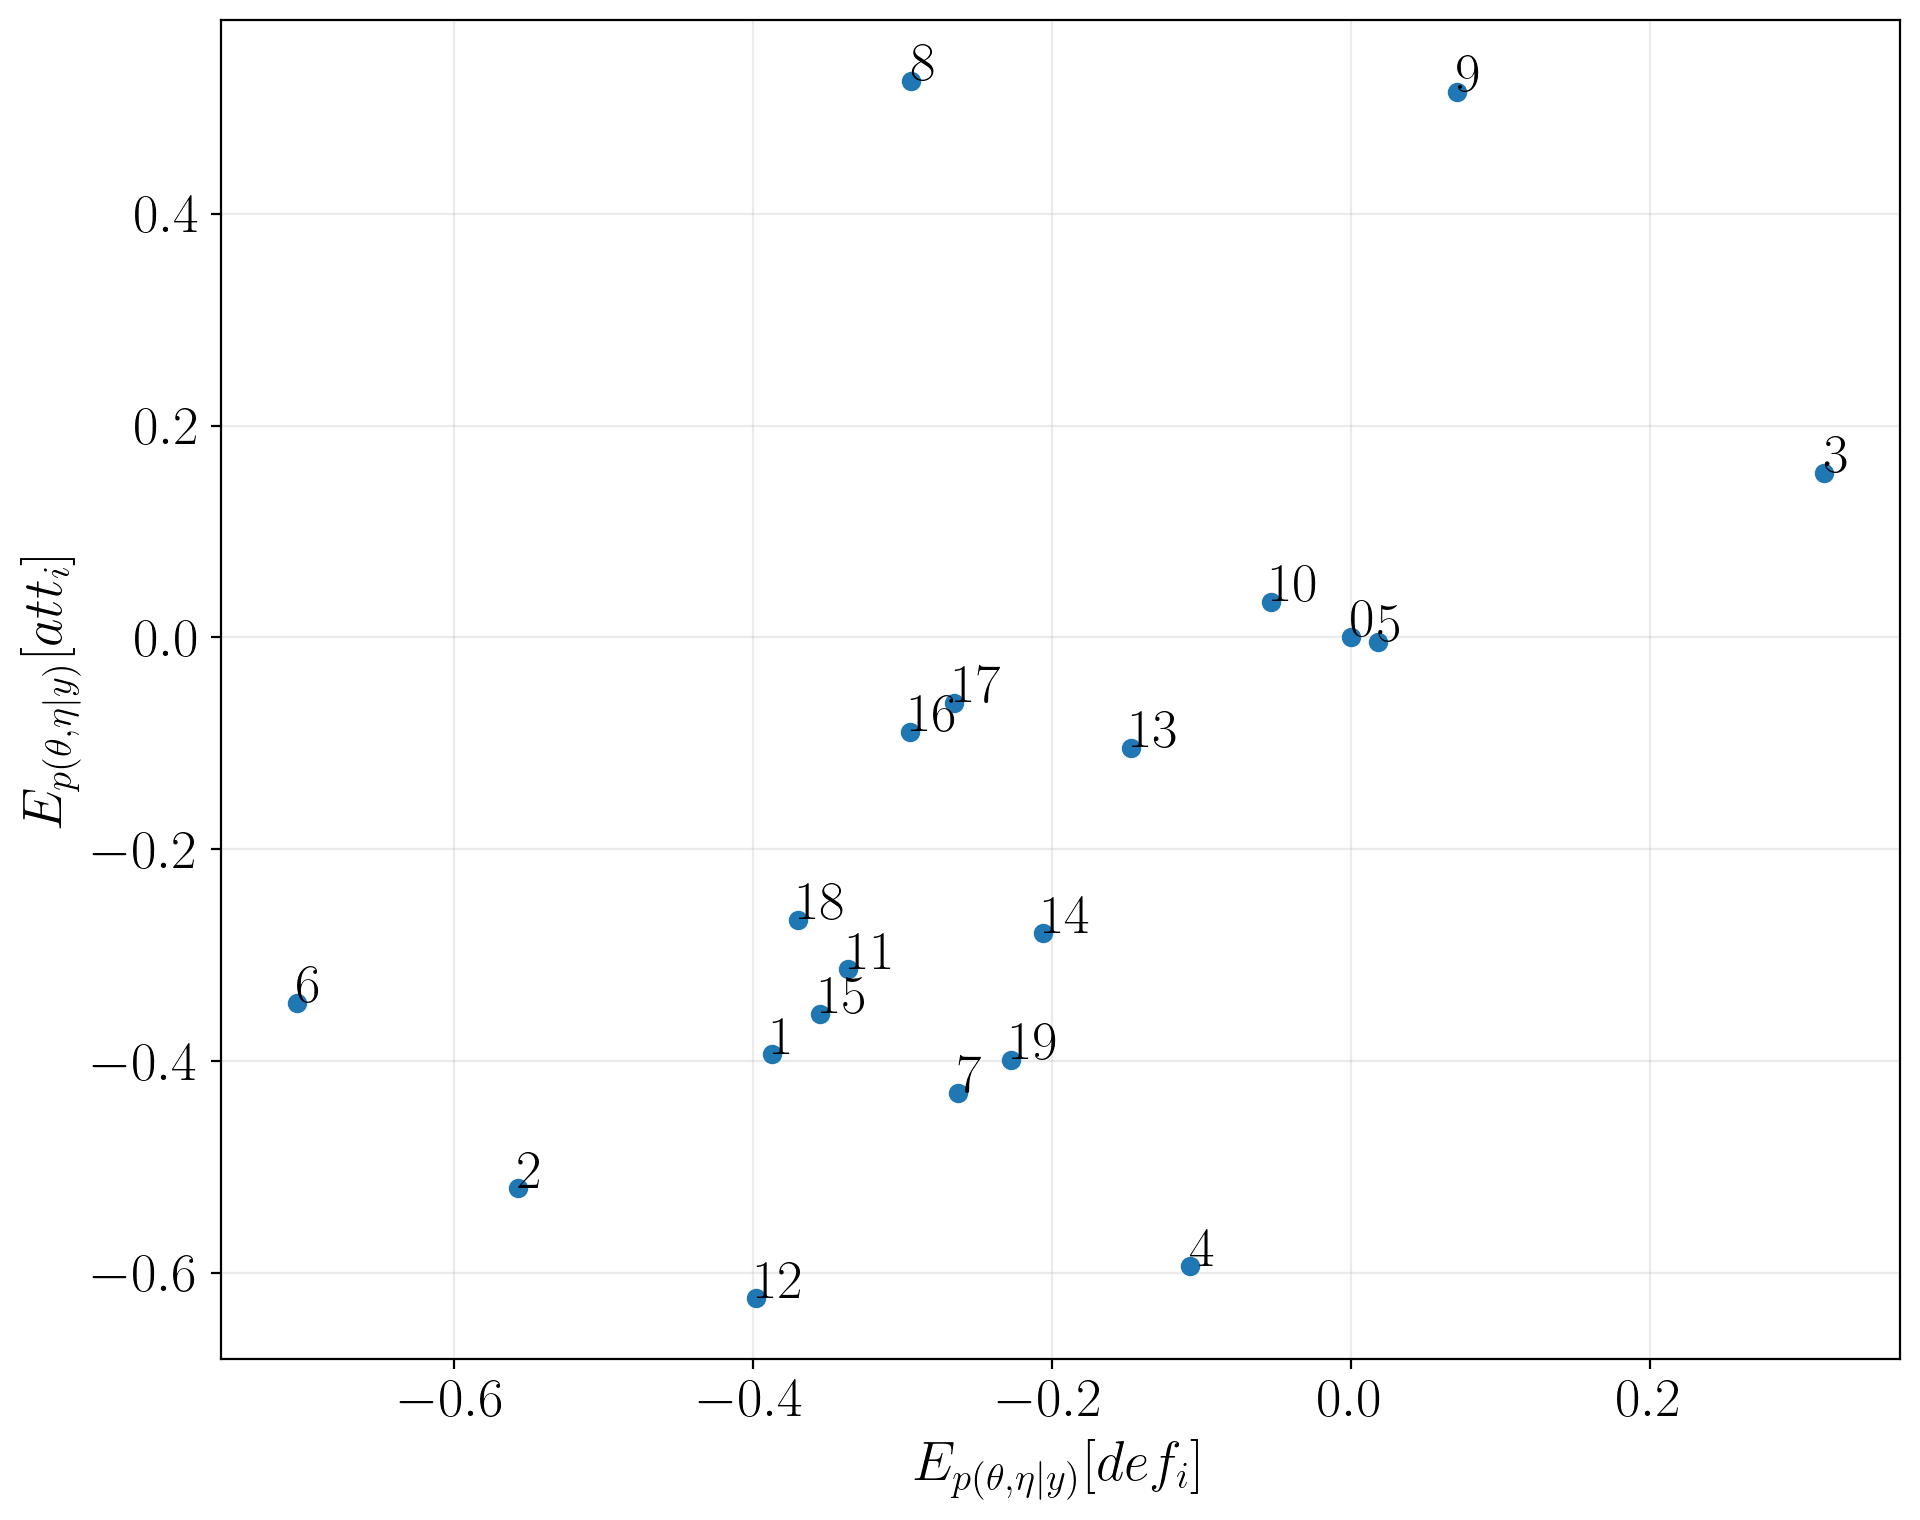

In [238]:
n_teams = 20
expected_attack = np.mean(samples[:,:n_teams], 0)
expected_defense = np.mean(samples[:,n_teams:-1], 0)

fig = plt.figure()
ax = plt.axes()
ax.plot(expected_defense, expected_attack, 'o')
for i in range(expected_defense.shape[0]):
    ax.text(expected_defense[i], expected_attack[i], str(i))
ax.set_xlabel(r'$E_{p(\theta,\eta\mid y)}[def_i]$')
ax.set_ylabel(r'$E_{p(\theta,\eta\mid y)}[att_i]$')
ax.grid(True, alpha=0.25)
fig.tight_layout()
# fig.savefig(f'report-images/attack_vs_defense.png', dpi=300)
plt.show()